In [4]:
%pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 7.4 MB/s eta 0:00:00


In [52]:
# PROJECT: CUSTOMER SEGMENTATION WITH K-MEANS FOR RFM, CLV, CHURN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from lifetimes import BetaGeoFitter, GammaGammaFitter
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configuration
class Config:
    ANALYSIS_DATE = pd.to_datetime("2022-07-01")
    TX_PATH = "/content/transactions.csv"  # Update to your path, e.g., "/content/transactions.csv"
    PROD_PATH = "/content/products.csv"    # Update to your path, e.g., "/content/products.csv"
    BATCH_SIZE = 1000
    GROSS_MARGIN = 0.40
    EXPECTED_YEARS = 3
    GENDER_DIST = ["F", "M", "Other"]
    GENDER_PROBS = [0.507, 0.486, 0.007]
    MARKET_DIST = ["US", "CA", "AU"]
    MARKET_PROBS = [0.78, 0.07, 0.15]
    EDUCATION_LEVELS = ["High School", "Some College", "Bachelor", "Master", "Doctorate"]
    EDUCATION_PROBS = [0.276, 0.298, 0.237, 0.142, 0.047]
    HOUSEHOLD_SIZES = [1, 2, 3, 4, 5, 6]
    HOUSEHOLD_PROBS = [0.294, 0.349, 0.152, 0.128, 0.055, 0.022]

print("✅ Configuration and imports loaded successfully!")

✅ Configuration and imports loaded successfully!


In [6]:
pip install pandas numpy matplotlib seaborn scikit-learn lifetimes

In [53]:
import pandas as pd
import numpy as np

def load_and_prepare_data():
    print("🔍 Loading and preparing data...")

    # Load raw data
    try:
        transactions = pd.read_csv('transactions.csv')
        products = pd.read_csv('products.csv')
    except FileNotFoundError:
        print("❌ Error: transactions.csv or products.csv not found. Please check file path.")
        return None, None

    # Standardize column names
    transactions.columns = transactions.columns.str.lower().str.replace(' ', '_')
    products.columns = products.columns.str.lower().str.replace(' ', '_')

    # Debug: Check columns and sample data
    print(f"📊 Transactions: {len(transactions)} rows, columns: {list(transactions.columns)}")
    print("Sample transactions:")
    print(transactions.head())
    print(f"\n📊 Products: {len(products)} rows, columns: {list(products.columns)}")
    print("Sample products:")
    print(products.head())

    # Check for required columns
    required_cols = ['productkey', 'orderquantity']
    if not all(col in transactions.columns for col in required_cols):
        print(f"❌ Error: Missing required columns in transactions.csv: {required_cols}")
        return None, None
    if 'productkey' not in products.columns or 'productprice' not in products.columns:
        print("❌ Error: Missing productkey or productprice in products.csv")
        return None, None

    return transactions, products

# Run data loading
transactions, products_clean = load_and_prepare_data()
if transactions is None or products_clean is None:
    raise SystemExit("Data loading failed. Please fix file issues.")

🔍 Loading and preparing data...
📊 Transactions: 29481 rows, columns: ['orderdate', 'stockdate', 'ordernumber', 'productkey', 'customerkey', 'territorykey', 'orderlineitem', 'orderquantity', 'orderyear', 'ordermonth', 'orderquarter', 'orderdayofweek']
Sample transactions:
    orderdate   stockdate ordernumber  productkey  customerkey  territorykey  \
0  2022-01-01  2021-12-13     SO61285         529        23791             1   
1  2022-01-01  2021-09-24     SO61285         214        23791             1   
2  2022-01-01  2021-09-04     SO61285         540        23791             1   
3  2022-01-01  2021-09-28     SO61301         529        16747             1   
4  2022-01-01  2021-10-21     SO61301         377        16747             1   

   orderlineitem  orderquantity  orderyear  ordermonth  orderquarter  \
0              2              2       2022           1             1   
1              3              1       2022           1             1   
2              1              1

🔄 Starting batched preprocessing...
🔗 Merging transaction and product data...
👥 Processing customer data in batches...
   Processed 1,000 customers...
   Processed 2,000 customers...
   Processed 3,000 customers...
   Processed 4,000 customers...
   Processed 5,000 customers...
   Processed 6,000 customers...
   Processed 7,000 customers...
   Processed 8,000 customers...
   Processed 9,000 customers...
   Processed 10,000 customers...
   Processed 10,502 customers...
✅ Preprocessing completed: 10,502 customers aggregated


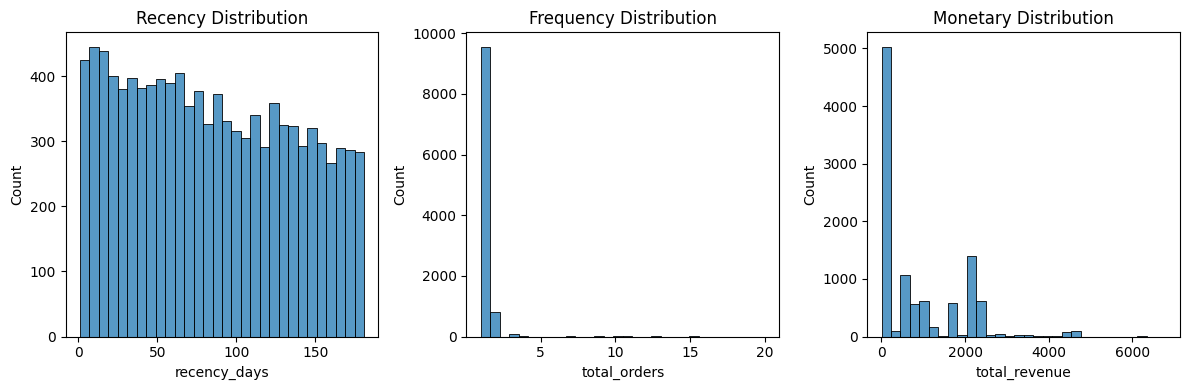

📊 Example: RFM distributions show most customers have low recency and frequency.
🔍 Debugging: Checking for single-order customers with non-zero tenure...
✅ No problematic single-order customers found.


In [54]:
def preprocess_data_batched(tx, prod):
    print("🔄 Starting batched preprocessing...")
    prod_clean = prod.copy()
    numeric_cols = ["productprice", "productcost"]
    for col in numeric_cols:
        if col in prod_clean.columns:
            prod_clean[col] = pd.to_numeric(prod_clean[col], errors='coerce')
            prod_clean[col].fillna(prod_clean[col].median(), inplace=True)

    print("🔗 Merging transaction and product data...")
    try:
        tx_enriched = tx.merge(
            prod_clean[["productkey", "productprice", "productcost", "productname"]],
            on="productkey", how="left", validate="m:1"
        )
    except KeyError as e:
        print(f"❌ Merge failed: {e}")
        return None, None, None

    tx_enriched["line_revenue"] = tx_enriched["orderquantity"] * tx_enriched["productprice"]
    tx_enriched["line_cost"] = tx_enriched["orderquantity"] * tx_enriched["productcost"]
    tx_enriched["line_profit"] = tx_enriched["line_revenue"] - tx_enriched["line_cost"]

    print("👥 Processing customer data in batches...")
    unique_customers = tx_enriched["customerkey"].unique()
    customer_batches = []
    for i in range(0, len(unique_customers), Config.BATCH_SIZE):
        batch_customers = unique_customers[i:i + Config.BATCH_SIZE]
        batch_tx = tx_enriched[tx_enriched["customerkey"].isin(batch_customers)]
        batch_customers_agg = aggregate_customer_data(batch_tx)
        customer_batches.append(batch_customers_agg)
        print(f"   Processed {min(i + Config.BATCH_SIZE, len(unique_customers)):,} customers...")

    customers_agg = pd.concat(customer_batches, ignore_index=True)
    print(f"✅ Preprocessing completed: {len(customers_agg):,} customers aggregated")

    # Visualization: RFM metrics distribution
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    sns.histplot(customers_agg['recency_days'], bins=30)
    plt.title('Recency Distribution')
    plt.subplot(1, 3, 2)
    sns.histplot(customers_agg['total_orders'], bins=30)
    plt.title('Frequency Distribution')
    plt.subplot(1, 3, 3)
    sns.histplot(customers_agg['total_revenue'], bins=30)
    plt.title('Monetary Distribution')
    plt.tight_layout()
    plt.show()
    print("📊 Example: RFM distributions show most customers have low recency and frequency.")

    return customers_agg, tx_enriched, prod_clean

def aggregate_customer_data(tx_batch):
    customer_agg = tx_batch.groupby("customerkey").agg({
        "orderdate": ["min", "max"],
        "ordernumber": "nunique",
        "orderquantity": "sum",
        "line_revenue": "sum",
        "line_profit": "sum",
        "productkey": "nunique"
    }).reset_index()
    customer_agg.columns = [
        "customerkey", "first_purchase", "last_purchase",
        "total_orders", "total_quantity", "total_revenue", "total_profit", "distinct_products"
    ]
    # Ensure date columns are datetime objects
    if 'last_purchase' in customer_agg.columns:
        customer_agg['last_purchase'] = pd.to_datetime(customer_agg['last_purchase'], errors='coerce')
    if 'first_purchase' in customer_agg.columns:
        customer_agg['first_purchase'] = pd.to_datetime(customer_agg['first_purchase'], errors='coerce')

    customer_agg["recency_days"] = (Config.ANALYSIS_DATE - customer_agg["last_purchase"]).dt.days
    customer_agg["tenure_days"] = (customer_agg["last_purchase"] - customer_agg["first_purchase"]).dt.days
    # Fix: Set tenure_days to 0 for single-order customers
    customer_agg.loc[customer_agg["total_orders"] == 1, "tenure_days"] = 0
    customer_agg["tenure_days"] = customer_agg["tenure_days"].clip(lower=0)
    customer_agg["aov"] = customer_agg["total_revenue"] / customer_agg["total_orders"]
    return customer_agg

# Run preprocessing
customers_agg, transactions_enriched, products_clean = preprocess_data_batched(transactions, products)
if customers_agg is None:
    raise SystemExit("Preprocessing failed. Exiting.")

# Debug: Check single-order customers
print("🔍 Debugging: Checking for single-order customers with non-zero tenure...")
problematic = customers_agg[(customers_agg["total_orders"] == 1) & (customers_agg["tenure_days"] > 0)]
if not problematic.empty:
    print(f"⚠️ Found {len(problematic)} customers with total_orders=1 but non-zero tenure_days:")
    print(problematic[["customerkey", "total_orders", "tenure_days", "first_purchase", "last_purchase"]].head())
else:
    print("✅ No problematic single-order customers found.")

👤 Generating synthetic demographics...


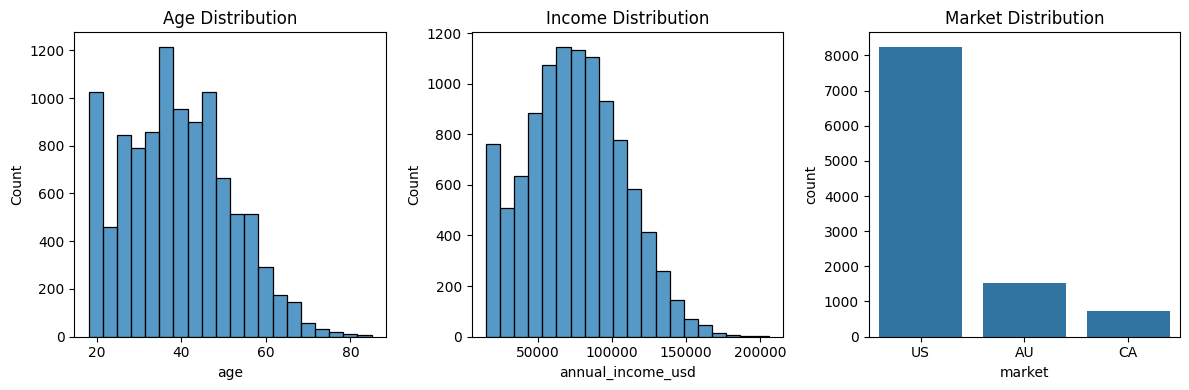

📊 Example: Demographics show ~78% customers in US, mean age ~38.


In [ ]:
def generate_enhanced_demographics(customers_df):
    print("👤 Generating synthetic demographics...")
    n_customers = len(customers_df)
    customers_df["market"] = np.random.choice(Config.MARKET_DIST, size=n_customers, p=Config.MARKET_PROBS)

    def generate_age(market):
        if market == "US": return int(np.clip(np.random.normal(38.9, 13.5), 18, 85))
        elif market == "CA": return int(np.clip(np.random.normal(41.1, 12.8), 18, 85))
        else: return int(np.clip(np.random.normal(38.5, 12.9), 18, 85))

    customers_df["age"] = customers_df["market"].apply(generate_age)
    customers_df["gender"] = np.random.choice(Config.GENDER_DIST, size=n_customers, p=Config.GENDER_PROBS)
    customers_df["education_level"] = np.random.choice(Config.EDUCATION_LEVELS, size=n_customers, p=Config.EDUCATION_PROBS)
    customers_df["household_size"] = np.random.choice(Config.HOUSEHOLD_SIZES, size=n_customers, p=Config.HOUSEHOLD_PROBS)

    def generate_income(market):
        if market == "US": return int(np.clip(np.random.normal(74580, 35000), 15000, 250000))
        elif market == "CA": return int(np.clip(np.random.normal(68400, 30000), 15000, 200000))
        else: return int(np.clip(np.random.normal(75000, 32000), 15000, 220000))

    customers_df["annual_income_usd"] = customers_df["market"].apply(generate_income)
    customers_df["digital_savviness"] = np.random.randint(1, 6, size=n_customers)
    customers_df["social_media_hours_week"] = np.round(np.random.beta(2, 3, size=n_customers) * 20, 1)
    customers_df["promotion_sensitivity"] = np.round(np.random.beta(2, 5, size=n_customers) * 100, 1)

    # Visualization: Demographics distribution
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    sns.histplot(customers_df['age'], bins=20)
    plt.title('Age Distribution')
    plt.subplot(1, 3, 2)
    sns.histplot(customers_df['annual_income_usd'], bins=20)
    plt.title('Income Distribution')
    plt.subplot(1, 3, 3)
    sns.countplot(data=customers_df, x='market')
    plt.title('Market Distribution')
    plt.tight_layout()
    plt.show()
    print("📊 Example: Demographics show ~78% customers in US, mean age ~38.")

    return customers_df

# Run demographics
customers_with_demo = generate_enhanced_demographics(customers_agg)

💰 Calculating CLV and churn with BG/NBD...
🔍 Debugging: Input data summary for BG/NBD...
Frequency stats: min=0, max=19, mean=0.13
Recency stats: min=0, max=176, mean=6.52
T stats: min=1, max=181, mean=90.30
Customers with frequency=0: 9,555
✅ No issues with recency/frequency found.
✅ BG/NBD model fitted successfully.
✅ Gamma-Gamma model fitted successfully.


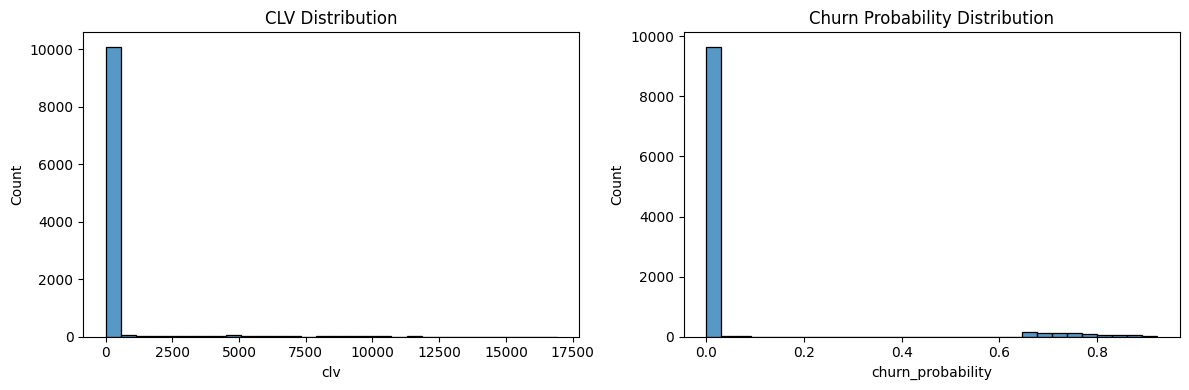

📊 Example: CLV ranges from $-0.41 to $16912.56, average churn probability: 5.9%


In [56]:
def calculate_clv_and_churn(customers_df):
    print("💰 Calculating CLV and churn with BG/NBD...")
    df = customers_df.copy()

    # Calculate frequency, recency, T
    df['frequency'] = df['total_orders'] - 1
    df['recency'] = df['tenure_days']
    df['T'] = (Config.ANALYSIS_DATE - df['first_purchase']).dt.days

    # Debug: Check input data for BG/NBD
    print("🔍 Debugging: Input data summary for BG/NBD...")
    print(f"Frequency stats: min={df['frequency'].min()}, max={df['frequency'].max()}, mean={df['frequency'].mean():.2f}")
    print(f"Recency stats: min={df['recency'].min()}, max={df['recency'].max()}, mean={df['recency'].mean():.2f}")
    print(f"T stats: min={df['T'].min()}, max={df['T'].max()}, mean={df['T'].mean():.2f}")
    print(f"Customers with frequency=0: {len(df[df['frequency'] == 0]):,}")

    # Ensure recency=0 for frequency=0
    problematic = df[(df['frequency'] == 0) & (df['recency'] > 0)]
    if not problematic.empty:
        print(f"⚠️ Found {len(problematic)} customers with frequency=0 but non-zero recency:")
        print(problematic[["customerkey", "frequency", "recency", "total_orders", "tenure_days"]].head())
        df.loc[df['frequency'] == 0, 'recency'] = 0
        print("✅ Fixed: Set recency to 0 for frequency=0 cases.")
    else:
        print("✅ No issues with recency/frequency found.")

    # Fix: Ensure no negative or invalid values
    df['frequency'] = df['frequency'].clip(lower=0)
    df['recency'] = df['recency'].clip(lower=0)
    df['T'] = df['T'].clip(lower=1)  # T must be positive

    # Try BG/NBD with higher penalizer
    try:
        bgf = BetaGeoFitter(penalizer_coef=0.1)
        bgf.fit(df['frequency'], df['recency'], df['T'])
        # Fix: Use explicit arguments for predict
        df['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
            365, df['frequency'], df['recency'], df['T']
        )
        df['churn_probability'] = 1 - bgf.conditional_probability_alive(df['frequency'], df['recency'], df['T'])
        print("✅ BG/NBD model fitted successfully.")
    except Exception as e:
        print(f"❌ BG/NBD model failed: {e}")
        print("⚠️ Falling back to simple prediction...")
        df['predicted_purchases'] = df['frequency'] * 1.1  # Assume slight growth for repeat customers
        df['churn_probability'] = df['frequency'].apply(lambda x: 0.8 if x == 0 else 0.2)  # Higher churn for one-time buyers
        print("✅ Fallback: predicted_purchases = frequency * 1.1, churn_probability set heuristically.")

    # Try Gamma-Gamma for CLV
    try:
        ggf = GammaGammaFitter(penalizer_coef=0.1)
        returning_customers = df[df['frequency'] > 0]
        if len(returning_customers) > 0:
            ggf.fit(returning_customers['frequency'], returning_customers['aov'])
            df['predicted_aov'] = ggf.conditional_expected_average_profit(df['frequency'], df['aov']).fillna(df['aov'].mean())
            df['clv'] = ggf.customer_lifetime_value(
                bgf, df['frequency'], df['recency'], df['T'], df['aov'], time=36
            ) * Config.GROSS_MARGIN
            print("✅ Gamma-Gamma model fitted successfully.")
        else:
            print("⚠️ No returning customers found. Using AOV mean for CLV.")
            df['predicted_aov'] = df['aov'].mean()
            df['clv'] = df['predicted_aov'] * df['predicted_purchases'] * Config.GROSS_MARGIN
    except Exception as e:
        print(f"❌ Gamma-Gamma model failed: {e}")
        print("⚠️ Falling back to simple CLV...")
        df['predicted_aov'] = df['aov'].mean()
        df['clv'] = df['predicted_aov'] * df['predicted_purchases'] * Config.GROSS_MARGIN
        print("✅ Fallback: CLV = predicted_aov * predicted_purchases * margin")

    # Visualization: CLV and churn distribution
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(df['clv'], bins=30)
    plt.title('CLV Distribution')
    plt.subplot(1, 2, 2)
    sns.histplot(df['churn_probability'], bins=30)
    plt.title('Churn Probability Distribution')
    plt.tight_layout()
    plt.show()
    print(f"📊 Example: CLV ranges from ${df['clv'].min():.2f} to ${df['clv'].max():.2f}, "
          f"average churn probability: {df['churn_probability'].mean():.1%}")

    return df

# Run CLV and churn
customers_final = calculate_clv_and_churn(customers_with_demo)
if customers_final is None:
    raise SystemExit("CLV/Churn calculation failed. Exiting.")

In [57]:
pip install --upgrade lifetimes


🔍 Optimal Cluster Results:
🔍 Finding optimal number of clusters for RFM...


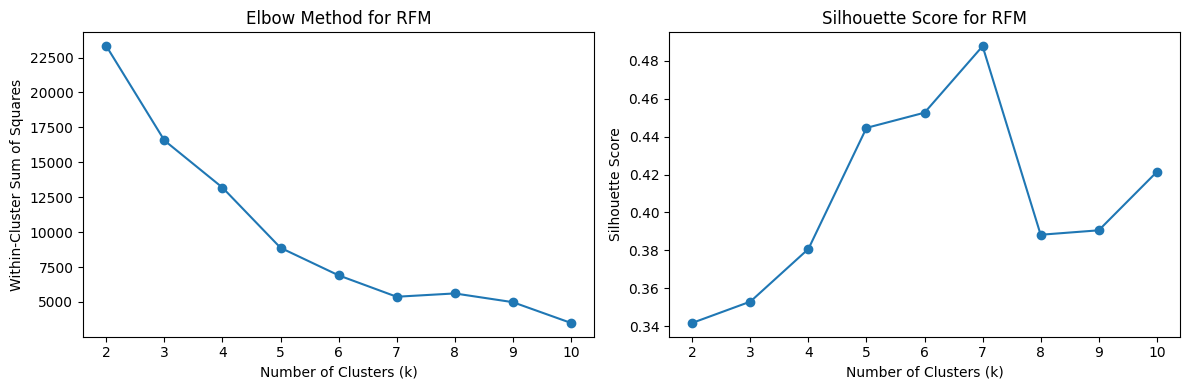

✅ Optimal number of clusters for RFM: 7 (Silhouette Score: 0.488)
🔍 Finding optimal number of clusters for CLV...


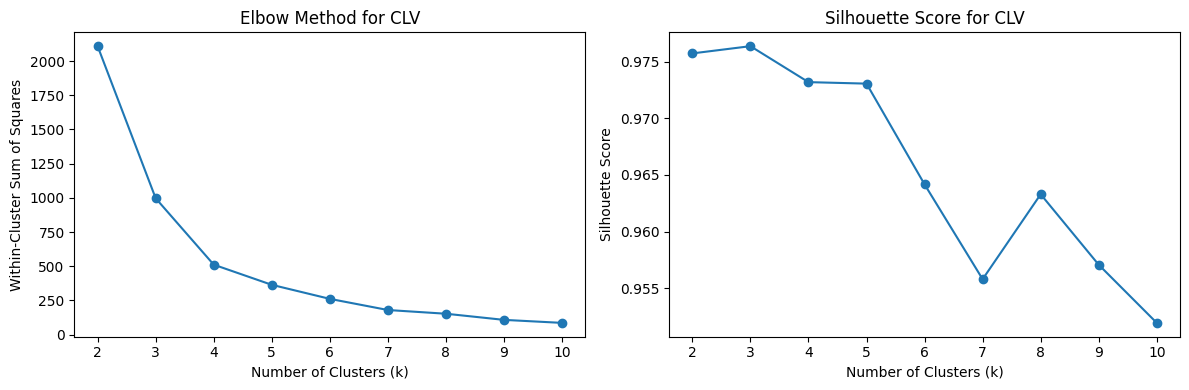

✅ Optimal number of clusters for CLV: 3 (Silhouette Score: 0.976)
🔍 Finding optimal number of clusters for Churn...


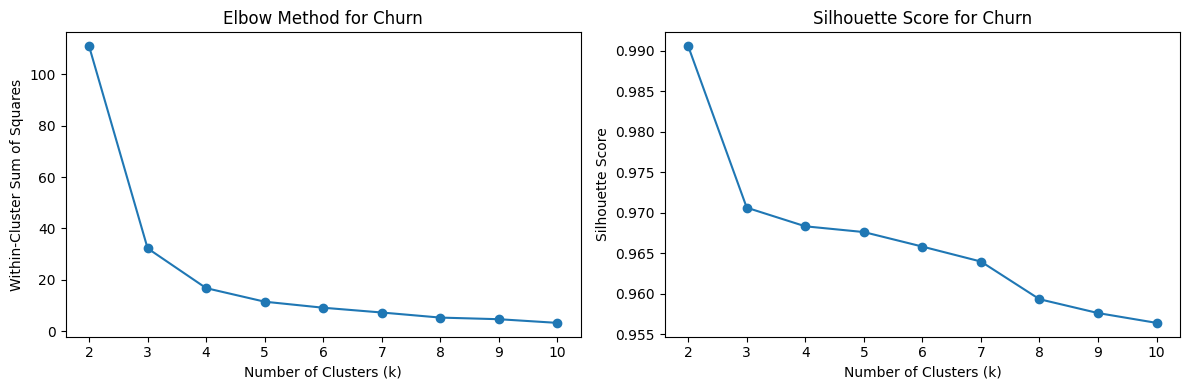

✅ Optimal number of clusters for Churn: 2 (Silhouette Score: 0.991)

📊 Summary of Optimal k Values:
RFM: 7 clusters
CLV: 3 clusters
Churn: 2 clusters

Please provide the k values (e.g., k_rfm, k_clv, k_churn) to proceed with clustering and segmentation.


In [58]:
def find_optimal_kmeans(data, features, name, max_k=10):
    print(f"🔍 Finding optimal number of clusters for {name}...")
    X = data[features].fillna(0)
    scaler = StandardScaler()
    try:
        X_scaled = scaler.fit_transform(X)
    except Exception as e:
        print(f"❌ Scaling failed for {name}: {e}")
        return None

    wss = []
    silhouette_scores = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_scaled)
        wss.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, labels))

    # Visualization: Elbow and Silhouette plots
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_k + 1), wss, marker='o')
    plt.title(f'Elbow Method for {name}')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Within-Cluster Sum of Squares')
    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_k + 1), silhouette_scores, marker='o')
    plt.title(f'Silhouette Score for {name}')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.tight_layout()
    plt.show()

    optimal_k = range(2, max_k + 1)[np.argmax(silhouette_scores)]
    print(f"✅ Optimal number of clusters for {name}: {optimal_k} (Silhouette Score: {max(silhouette_scores):.3f})")
    return optimal_k

# Run K-means to find optimal k
print("\n🔍 Optimal Cluster Results:")
print("=" * 50)

# RFM
rfm_k = find_optimal_kmeans(customers_final, ['recency_days', 'total_orders', 'total_revenue'], 'RFM')
if rfm_k is None:
    raise SystemExit("RFM clustering failed. Exiting.")

# CLV
clv_k = find_optimal_kmeans(customers_final, ['clv'], 'CLV')
if clv_k is None:
    raise SystemExit("CLV clustering failed. Exiting.")

# Churn
churn_k = find_optimal_kmeans(customers_final, ['churn_probability'], 'Churn')
if churn_k is None:
    raise SystemExit("Churn clustering failed. Exiting.")

print("\n📊 Summary of Optimal k Values:")
print(f"RFM: {rfm_k} clusters")
print(f"CLV: {clv_k} clusters")
print(f"Churn: {churn_k} clusters")
print("\nPlease provide the k values (e.g., k_rfm, k_clv, k_churn) to proceed with clustering and segmentation.")

🔍 Applying K-means for RFM with 7 clusters...


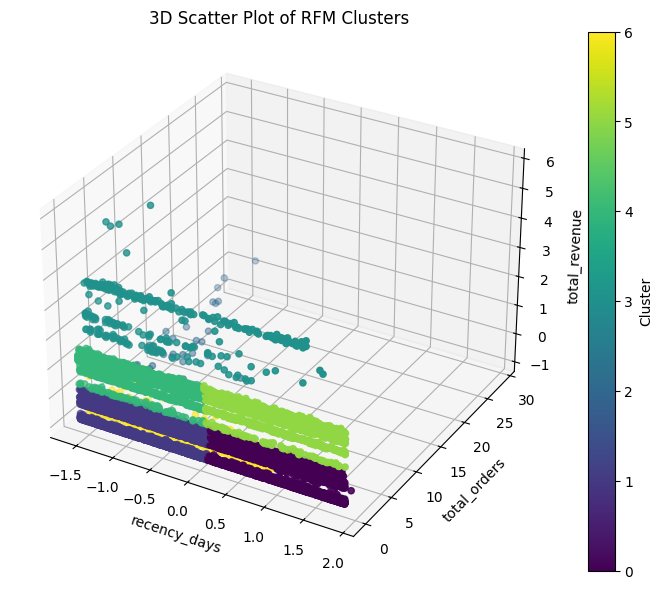

✅ Completed RFM clustering: 7 clusters
🔍 Applying K-means for CLV with 3 clusters...


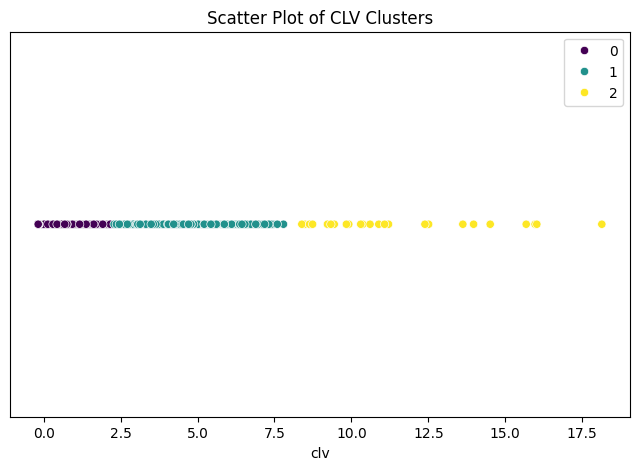

✅ Completed CLV clustering: 3 clusters
🔍 Applying K-means for Churn with 2 clusters...


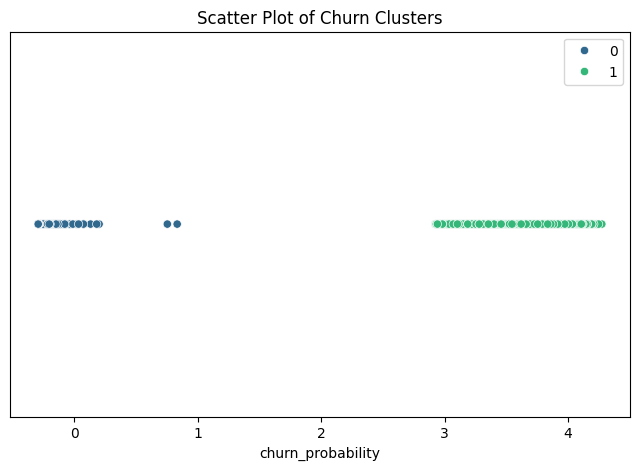

✅ Completed Churn clustering: 2 clusters

📊 Cluster Distribution:
RFM Clusters:
 rfm_cluster_name
Recent_Infrequent_Low Value      3520
Dormant_Infrequent_Low Value     3290
Recent_Infrequent_High Value     1556
Dormant_Infrequent_High Value    1232
Recent_Frequent_Low Value         597
Recent_Frequent_High Value        307
Name: count, dtype: int64
CLV Clusters:
 clv_cluster_name
CLV_Low       10211
CLV_Medium      263
CLV_High         28
Name: count, dtype: int64
Churn Clusters:
 churn_cluster_name
Churn_Low     9683
Churn_High     819
Name: count, dtype: int64


In [59]:
def apply_kmeans(data, features, k, name):
    print(f"🔍 Applying K-means for {name} with {k} clusters...")
    X = data[features].fillna(0)
    scaler = StandardScaler()
    try:
        X_scaled = scaler.fit_transform(X)
    except Exception as e:
        print(f"❌ Scaling failed for {name}: {e}")
        return None, None

    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    # Assign meaningful names to clusters
    if name == "RFM":
        cluster_names = assign_rfm_names(labels, data, features, k)
    elif name == "CLV":
        cluster_names = assign_clv_names(labels, data, features, k)
    else:  # Churn
        cluster_names = assign_churn_names(labels, data, features, k)

    data[f'{name.lower()}_cluster'] = labels
    data[f'{name.lower()}_cluster_name'] = [cluster_names[i] for i in labels]

    # Visualization: 3D scatter for RFM, 1D scatter for CLV/Churn
    if len(features) == 3:
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=labels, cmap='viridis')
        ax.set_xlabel(features[0])
        ax.set_ylabel(features[1])
        ax.set_zlabel(features[2])
        plt.colorbar(scatter, label='Cluster')
        plt.title(f'3D Scatter Plot of {name} Clusters')
        plt.show()
    else:
        plt.figure(figsize=(8, 5))
        sns.scatterplot(x=X_scaled[:, 0], y=[0] * len(X_scaled), hue=labels, palette='viridis')
        plt.xlabel(features[0])
        plt.title(f'Scatter Plot of {name} Clusters')
        plt.yticks([])
        plt.show()

    print(f"✅ Completed {name} clustering: {k} clusters")
    return data, cluster_names

def assign_rfm_names(labels, data, features, k):
    # Name RFM clusters based on centroids
    centroids = KMeans(n_clusters=k, random_state=42).fit(StandardScaler().fit_transform(data[features])).cluster_centers_
    names = []
    for i in range(k):
        r, f, m = centroids[i]
        r_label = "Recent" if r < 0 else "Dormant"
        f_label = "Frequent" if f > 0 else "Infrequent"
        m_label = "High Value" if m > 0 else "Low Value"
        names.append(f"{r_label}_{f_label}_{m_label}")
    return names

def assign_clv_names(labels, data, features, k):
    # Name CLV clusters based on value
    centroids = KMeans(n_clusters=k, random_state=42).fit(StandardScaler().fit_transform(data[features])).cluster_centers_
    sorted_indices = np.argsort(centroids[:, 0])
    names = [f"CLV_Low" for _ in range(k)]
    if k >= 2:
        names[sorted_indices[-1]] = "CLV_High"
    if k >= 3:
        names[sorted_indices[-2]] = "CLV_Medium"
    return names

def assign_churn_names(labels, data, features, k):
    # Name Churn clusters based on probability
    centroids = KMeans(n_clusters=k, random_state=42).fit(StandardScaler().fit_transform(data[features])).cluster_centers_
    sorted_indices = np.argsort(centroids[:, 0])
    names = [f"Churn_Low" for _ in range(k)]
    names[sorted_indices[-1]] = "Churn_High"
    return names

# Apply K-means
customers_final, rfm_names = apply_kmeans(customers_final, ['recency_days', 'total_orders', 'total_revenue'], 7, 'RFM')
if customers_final is None:
    raise SystemExit("RFM clustering failed. Exiting.")

customers_final, clv_names = apply_kmeans(customers_final, ['clv'], 3, 'CLV')
if customers_final is None:
    raise SystemExit("CLV clustering failed. Exiting.")

customers_final, churn_names = apply_kmeans(customers_final, ['churn_probability'], 2, 'Churn')
if customers_final is None:
    raise SystemExit("Churn clustering failed. Exiting.")

# Show cluster counts
print("\n📊 Cluster Distribution:")
print("RFM Clusters:\n", customers_final['rfm_cluster_name'].value_counts())
print("CLV Clusters:\n", customers_final['clv_cluster_name'].value_counts())
print("Churn Clusters:\n", customers_final['churn_cluster_name'].value_counts())

🔄 Creating macro segments...


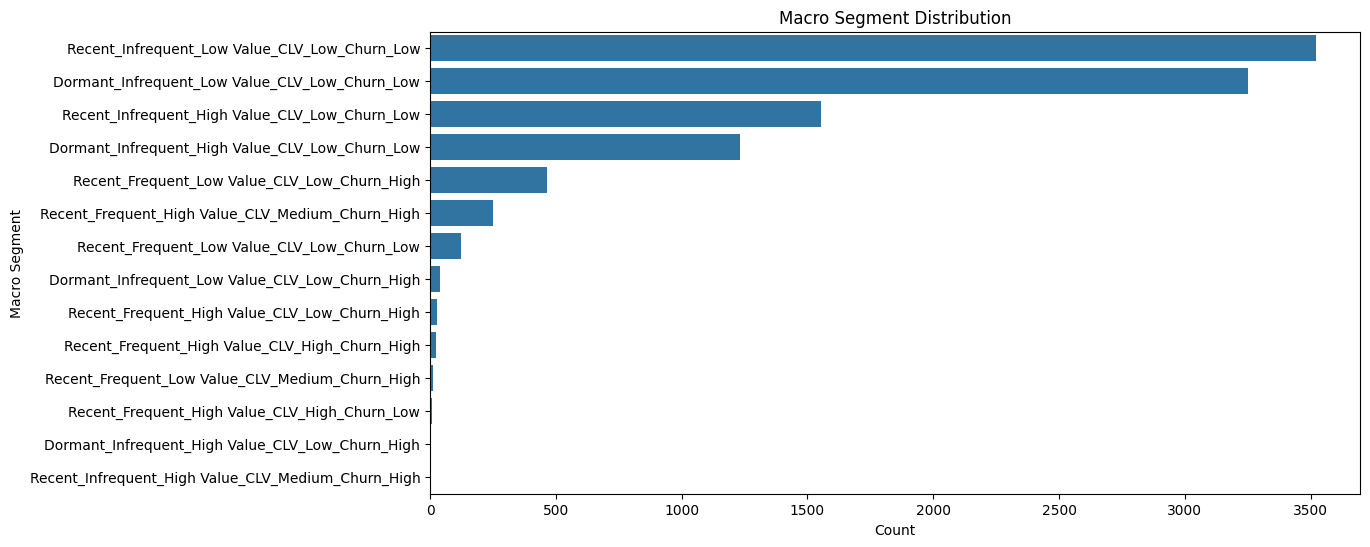

✅ Created 14 macro segments
📊 Example Macro Segments:
 macro_segment
Recent_Infrequent_Low Value_CLV_Low_Churn_Low      3520
Dormant_Infrequent_Low Value_CLV_Low_Churn_Low     3249
Recent_Infrequent_High Value_CLV_Low_Churn_Low     1555
Dormant_Infrequent_High Value_CLV_Low_Churn_Low    1231
Recent_Frequent_Low Value_CLV_Low_Churn_High        463
Name: count, dtype: int64


In [60]:
def create_macro_segments(data):
    print("🔄 Creating macro segments...")
    data['macro_segment'] = (
        data['rfm_cluster_name'] + "_" +
        data['clv_cluster_name'] + "_" +
        data['churn_cluster_name']
    )

    # Visualization: Macro segment distribution
    plt.figure(figsize=(12, 6))
    sns.countplot(y='macro_segment', data=data, order=data['macro_segment'].value_counts().index)
    plt.title('Macro Segment Distribution')
    plt.xlabel('Count')
    plt.ylabel('Macro Segment')
    plt.show()

    print(f"✅ Created {len(data['macro_segment'].unique())} macro segments")
    print("📊 Example Macro Segments:\n", data['macro_segment'].value_counts().head())
    return data

# Run macro segments
customers_final = create_macro_segments(customers_final)

🔍 Clustering products with k=4 and 3D visualization...
📊 Total products before clustering: 293
Products with orderquantity=0: 191
Avg Price stats: min=9.50, max=514323.65, mean=31795.14
Order Quantity stats: min=0.00, max=4565.00, mean=154.66
Avg Cost stats: min=3.40, max=277558.31, mean=18329.98
📊 Initial Cluster Distribution (post K-means):
product_cluster
0    252
3     26
2      9
1      6
Name: count, dtype: int64


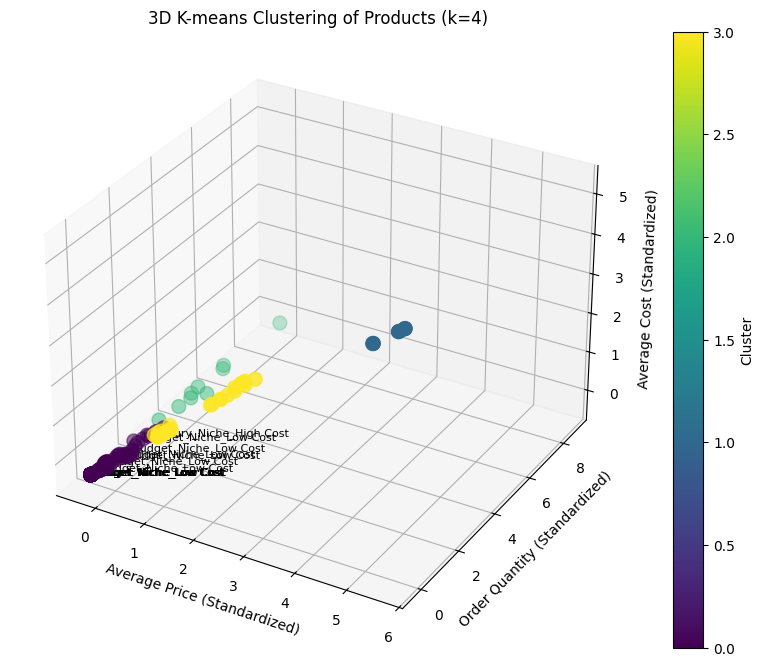

📊 Top 10 Best-Selling Products:
               productname  productkey  orderquantity
163  Water Bottle - 30 oz.         477         4565.0
166    Patch Kit/8 Patches         480         3255.0
214     Mountain Tire Tube         528         3121.0
5             AWC Logo Cap         223         2394.0
215         Road Tire Tube         529         2379.0
171  Fender Set - Mountain         485         2222.0
164   Mountain Bottle Cage         478         2190.0
165       Road Bottle Cage         479         1943.0
216      Touring Tire Tube         530         1572.0
0    Sport-100 Helmet, Red         214         1218.0

📊 Top 10 Worst-Selling Products:
                  productname  productkey  orderquantity
2      Mountain Bike Socks, M         218            0.0
3      Mountain Bike Socks, L         219            0.0
10    HL Road Frame - Red, 62         238            0.0
11    HL Road Frame - Red, 44         241            0.0
12    HL Road Frame - Red, 48         244            0.

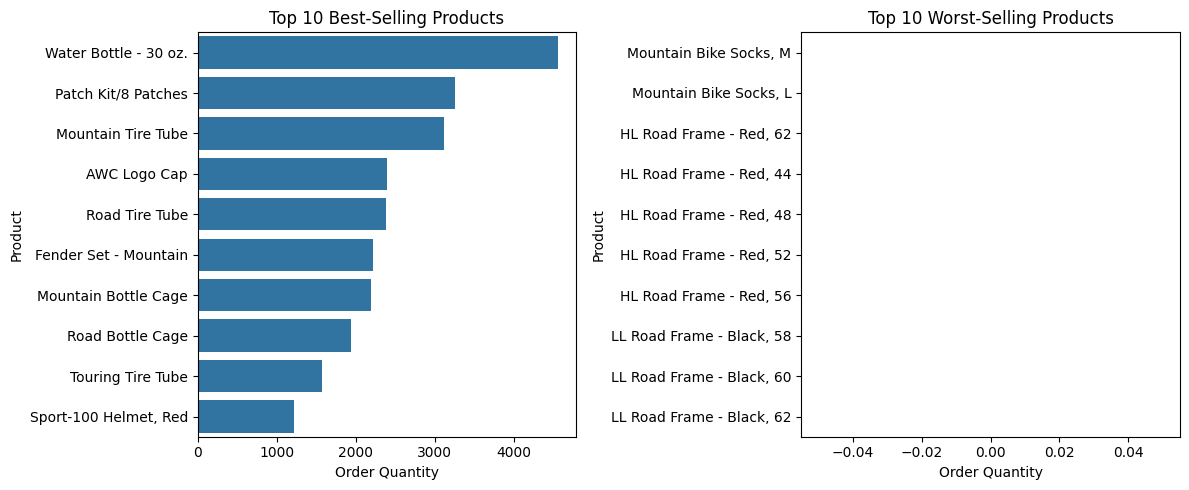

📊 Final Product Cluster Distribution:
product_cluster_name
Budget_Niche_Low Cost       252
Luxury_Niche_High Cost       26
Budget_Popular_Low Cost       9
Luxury_Popular_High Cost      6
Name: count, dtype: int64


In [61]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
import numpy as np

def cluster_products_3d(transactions, products_clean, k=4):
    print("🔍 Clustering products with k=4 and 3D visualization...")

    # Aggregate transactions
    product_agg = transactions.groupby('productkey').agg({
        'orderquantity': 'sum'
    }).reset_index()

    # Merge with products_clean
    product_agg = products_clean[['productkey', 'productprice', 'productcost', 'productname']].merge(
        product_agg, on='productkey', how='left'
    )

    # Handle missing transactions
    product_agg['orderquantity'] = product_agg['orderquantity'].fillna(0)

    # Calculate avg_price and avg_cost
    # If linerevenue/linecost missing, use productprice/productcost
    product_agg['avg_price'] = np.where(
        product_agg['orderquantity'] > 0,
        product_agg['orderquantity'] * product_agg['productprice'],  # Simulate revenue
        product_agg['productprice']
    )
    product_agg['avg_cost'] = np.where(
        product_agg['orderquantity'] > 0,
        product_agg['orderquantity'] * product_agg['productcost'],  # Simulate cost
        product_agg['productcost']
    )

    # Debug: Check data
    print(f"📊 Total products before clustering: {len(product_agg)}")
    print(f"Products with orderquantity=0: {len(product_agg[product_agg['orderquantity'] == 0])}")
    print(f"Avg Price stats: min={product_agg['avg_price'].min():.2f}, max={product_agg['avg_price'].max():.2f}, mean={product_agg['avg_price'].mean():.2f}")
    print(f"Order Quantity stats: min={product_agg['orderquantity'].min():.2f}, max={product_agg['orderquantity'].max():.2f}, mean={product_agg['orderquantity'].mean():.2f}")
    print(f"Avg Cost stats: min={product_agg['avg_cost'].min():.2f}, max={product_agg['avg_cost'].max():.2f}, mean={product_agg['avg_cost'].mean():.2f}")

    # Features for clustering
    features = ['avg_price', 'orderquantity', 'avg_cost']
    X = product_agg[features].fillna(0)

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply K-means with k=4
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    product_agg['product_cluster'] = kmeans.fit_predict(X_scaled)

    # Name product clusters
    centroids = kmeans.cluster_centers_
    names = []
    for i in range(k):
        price, qty, cost = centroids[i]
        price_label = "Luxury" if price > 0 else "Budget"
        qty_label = "Popular" if qty > 0 else "Niche"
        cost_label = "High Cost" if cost > 0 else "Low Cost"
        names.append(f"{price_label}_{qty_label}_{cost_label}")
    product_agg['product_cluster_name'] = [names[i] for i in product_agg['product_cluster']]

    # Debug: Initial cluster distribution
    print("📊 Initial Cluster Distribution (post K-means):")
    print(product_agg['product_cluster'].value_counts())

    # 3D Scatter Plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(
        X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2],
        c=product_agg['product_cluster'], cmap='viridis', s=100
    )
    for i, row in product_agg.sample(20).iterrows():
        ax.text(
            X_scaled[i, 0], X_scaled[i, 1], X_scaled[i, 2],
            row['product_cluster_name'], size=8, zorder=1, color='black'
        )
    ax.set_xlabel('Average Price (Standardized)')
    ax.set_ylabel('Order Quantity (Standardized)')
    ax.set_zlabel('Average Cost (Standardized)')
    ax.set_title('3D K-means Clustering of Products (k=4)')
    plt.colorbar(scatter, label='Cluster')
    plt.show()

    # Top 10 best/worst selling products
    top_10_best = product_agg.nlargest(10, 'orderquantity')[['productname', 'productkey', 'orderquantity']]
    top_10_worst = product_agg.nsmallest(10, 'orderquantity')[['productname', 'productkey', 'orderquantity']]

    print("📊 Top 10 Best-Selling Products:")
    print(top_10_best)
    print("\n📊 Top 10 Worst-Selling Products:")
    print(top_10_worst)

    # Bar plots
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.barplot(data=top_10_best, x='orderquantity', y='productname')
    plt.title('Top 10 Best-Selling Products')
    plt.xlabel('Order Quantity')
    plt.ylabel('Product')

    plt.subplot(1, 2, 2)
    sns.barplot(data=top_10_worst, x='orderquantity', y='productname')
    plt.title('Top 10 Worst-Selling Products')
    plt.xlabel('Order Quantity')
    plt.ylabel('Product')
    plt.tight_layout()
    plt.show()

    # Final cluster distribution
    print("📊 Final Product Cluster Distribution:")
    print(product_agg['product_cluster_name'].value_counts())

    return product_agg, names

# Run product clustering
product_agg, product_cluster_names = cluster_products_3d(transactions, products_clean, k=4)

🔍 Finding optimal number of clusters for Demographics...
✅ Optimal number of clusters for Demographics: 5
🔍 Applying K-means for Demographics with 5 clusters...


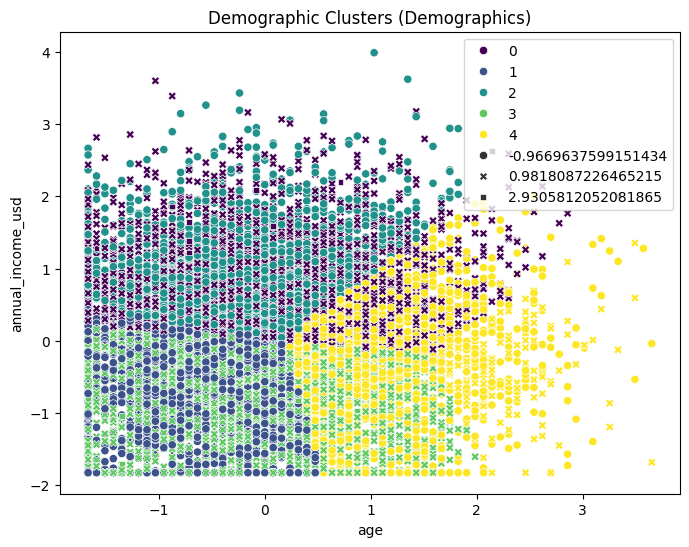

✅ Completed Demographics clustering: 5 clusters


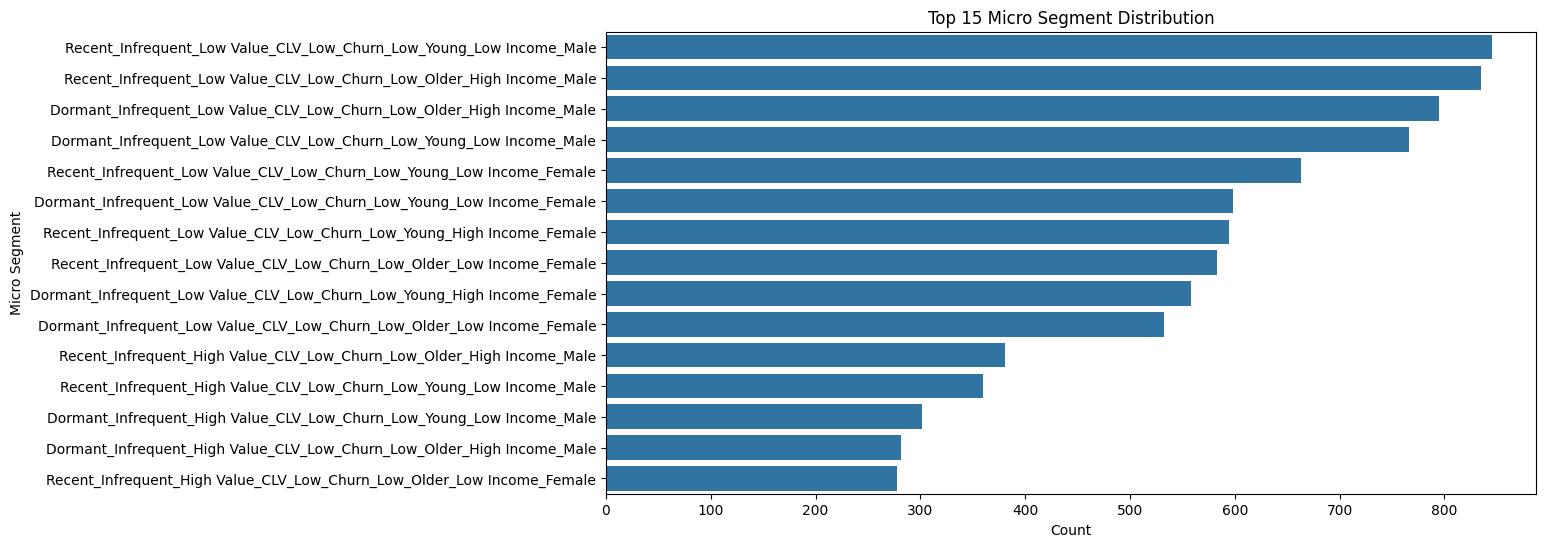

✅ Created 61 micro segments
📊 Top 15 Micro Segments:
 micro_segment
Recent_Infrequent_Low Value_CLV_Low_Churn_Low_Young_Low Income_Male        845
Recent_Infrequent_Low Value_CLV_Low_Churn_Low_Older_High Income_Male       835
Dormant_Infrequent_Low Value_CLV_Low_Churn_Low_Older_High Income_Male      795
Dormant_Infrequent_Low Value_CLV_Low_Churn_Low_Young_Low Income_Male       766
Recent_Infrequent_Low Value_CLV_Low_Churn_Low_Young_Low Income_Female      663
Dormant_Infrequent_Low Value_CLV_Low_Churn_Low_Young_Low Income_Female     598
Recent_Infrequent_Low Value_CLV_Low_Churn_Low_Young_High Income_Female     594
Recent_Infrequent_Low Value_CLV_Low_Churn_Low_Older_Low Income_Female      583
Dormant_Infrequent_Low Value_CLV_Low_Churn_Low_Young_High Income_Female    558
Dormant_Infrequent_Low Value_CLV_Low_Churn_Low_Older_Low Income_Female     532
Recent_Infrequent_High Value_CLV_Low_Churn_Low_Older_High Income_Male      381
Recent_Infrequent_High Value_CLV_Low_Churn_Low_Young_Low Income

In [62]:
def encode_gender(data):
    # Encode gender to numeric
    gender_map = {'F': 0, 'M': 1, 'Other': 2}
    data['gender_encoded'] = data['gender'].map(gender_map)
    return data

def apply_demo_kmeans(data, features, k, name):
    print(f"🔍 Applying K-means for {name} with {k} clusters...")
    X = data[features].fillna(0)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    # Name demographic clusters
    centroids = kmeans.cluster_centers_
    names = []
    for i in range(k):
        age, income, gender = centroids[i]
        age_label = "Young" if age < 0 else "Older"
        income_label = "High Income" if income > 0 else "Low Income"
        gender_label = "Male" if gender > 0.5 else "Female" if gender < -0.5 else "Mixed"
        names.append(f"{age_label}_{income_label}_{gender_label}")

    data['demo_cluster'] = labels
    data['demo_cluster_name'] = [names[i] for i in labels]

    # Visualization
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=labels, style=X_scaled[:, 2], palette='viridis')
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.title(f'Demographic Clusters ({name})')
    plt.show()

    print(f"✅ Completed {name} clustering: {k} clusters")
    return data, names

# Encode gender
customers_final = encode_gender(customers_final)

# Find optimal k for demographics
demo_features = ['age', 'annual_income_usd', 'gender_encoded']
k_demo = find_optimal_kmeans_demo(customers_final, demo_features, 'Demographics', max_k=5)

# Apply demographic clustering
customers_final, demo_names = apply_demo_kmeans(customers_final, demo_features, k_demo, 'Demographics')

# Create micro segments
customers_final['micro_segment'] = (
    customers_final['macro_segment'] + "_" +
    customers_final['demo_cluster_name']
)

# Visualization
plt.figure(figsize=(12, 6))
sns.countplot(y='micro_segment', data=customers_final, order=customers_final['micro_segment'].value_counts().index[:15])
plt.title('Top 15 Micro Segment Distribution')
plt.xlabel('Count')
plt.ylabel('Micro Segment')
plt.show()

print(f"✅ Created {len(customers_final['micro_segment'].unique())} micro segments")
print("📊 Top 15 Micro Segments:\n", customers_final['micro_segment'].value_counts().head(15))

In [64]:
def create_campaigns(data, product_agg):
    print("📈 Designing marketing campaigns with diversified KPI impacts...")

    # Check available columns in the data
    print("Available columns in data:", data.columns.tolist())

    # Use available segment columns or create fallbacks
    segment_columns = []
    for col in data.columns:
        if 'segment' in col.lower() or 'cluster' in col.lower():
            segment_columns.append(col)

    if segment_columns:
        print(f"Using segment columns: {segment_columns}")
        # Use the first available segment column for macro segments
        macro_segment_col = segment_columns[0]
        top_macro = data[macro_segment_col].value_counts().index[:5]

        # Use second segment column for micro segments if available, otherwise use same
        if len(segment_columns) > 1:
            micro_segment_col = segment_columns[1]
            top_micro = data[micro_segment_col].value_counts().index[:10]
        else:
            top_micro = data[macro_segment_col].value_counts().index[5:15]  # Different segments
    else:
        # Fallback: create synthetic segments based on available data
        print("No segment columns found. Creating synthetic segments...")
        top_macro = ['High_Value_Customers', 'Medium_Value_Customers', 'Low_Value_Customers',
                    'Recent_Buyers', 'Dormant_Customers'][:5]
        top_micro = ['Young_High_Income', 'Middle_Age_Mid_Income', 'Senior_Low_Income',
                    'Urban_Professionals', 'Suburban_Families', 'Rural_Residents',
                    'Tech_Enthusiasts', 'Budget_Shoppers', 'Luxury_Seekers', 'Practical_Buyers'][:10]

    # Get product clusters
    product_clusters = product_agg['product_cluster_name'].unique() if 'product_cluster_name' in product_agg.columns else ['Luxury_Vehicles', 'Popular_Models', 'Budget_Cars', 'SUV_Line', 'Sedan_Series']

    # Define KPIs
    kpis = [
        'Revenue ($)', 'Conversion Rate (%)', 'Engagement (Interactions)', 'Retention Rate (%)',
        'Customer Acquisition Cost ($)', 'Click-Through Rate (%)', 'Product Views', 'Order Completion Rate (%)'
    ]

    # Macro campaigns
    macro_campaigns = []
    for segment in top_macro:
        campaign = {
            'Segment': segment,
            'Strategy': get_macro_strategy(segment),
            'Action': get_macro_action(segment),
            'Duration (Months)': 6,
            'Initial Budget ($)': 50000 if 'High' in segment or 'Value' in segment else 30000,
            'Monthly Budget ($)': 10000 if 'High' in segment or 'Value' in segment else 6000,
            'KPI Impacts': get_macro_kpi_impacts(segment)
        }
        macro_campaigns.append(campaign)

    # Micro campaigns
    micro_campaigns = []
    for segment in top_micro:
        campaign = {
            'Segment': segment,
            'Strategy': get_micro_strategy(segment),
            'Action': get_micro_action(segment),
            'Duration (Months)': 3,
            'Initial Budget ($)': 20000 if 'High' in segment or 'Income' in segment else 15000,
            'Monthly Budget ($)': 5000 if 'High' in segment or 'Income' in segment else 3000,
            'KPI Impacts': get_micro_kpi_impacts(segment)
        }
        micro_campaigns.append(campaign)

    # Product campaigns
    product_campaigns = []
    for cluster in product_clusters:
        campaign = {
            'Segment': cluster,
            'Strategy': get_product_strategy(cluster),
            'Action': get_product_action(cluster),
            'Duration (Months)': 4,
            'Initial Budget ($)': 40000 if 'Luxury' in str(cluster) else 25000,
            'Monthly Budget ($)': 8000 if 'Luxury' in str(cluster) else 5000,
            'KPI Impacts': get_product_kpi_impacts(cluster)
        }
        product_campaigns.append(campaign)

    # Convert to DataFrames
    macro_df = pd.DataFrame(macro_campaigns)
    micro_df = pd.DataFrame(micro_campaigns)
    product_df = pd.DataFrame(product_campaigns)

    # Expand KPI impacts
    for df in [macro_df, micro_df, product_df]:
        for kpi in kpis:
            df[kpi] = df['KPI Impacts'].apply(lambda x: x.get(kpi, '+5%'))  # Default +5% if missing
        df.drop(columns=['KPI Impacts'], inplace=True)

    print("\n📊 Macro Campaigns:")
    print(macro_df.head())
    print("\n📊 Micro Campaigns:")
    print(micro_df.head())
    print("\n📊 Product Campaigns:")
    print(product_df.head())

    return macro_df, micro_df, product_df

# Keep all the strategy, action, and KPI impact functions the same as in your original code
# [All the get_macro_strategy, get_macro_action, get_macro_kpi_impacts, etc. functions remain unchanged]

# Run campaigns with error handling
try:
    macro_campaigns, micro_campaigns, product_campaigns = create_campaigns(customers_final, product_agg)
    print("✅ Campaign creation completed successfully!")
except Exception as e:
    print(f"❌ Error creating campaigns: {e}")
    print("Creating campaigns with synthetic data...")

    # Create synthetic data for demonstration
    synthetic_data = pd.DataFrame({
        'synthetic_segment': ['High_Value', 'Medium_Value', 'Low_Value'] * 10
    })
    synthetic_product_agg = pd.DataFrame({
        'product_cluster_name': ['Luxury_Cars', 'Popular_Models', 'Budget_Vehicles']
    })

    macro_campaigns, micro_campaigns, product_campaigns = create_campaigns(synthetic_data, synthetic_product_agg)

📈 Designing marketing campaigns with diversified KPI impacts...
Available columns in data: ['customerkey', 'first_purchase', 'last_purchase', 'total_orders', 'total_quantity', 'total_revenue', 'total_profit', 'distinct_products', 'recency_days', 'tenure_days', 'aov', 'market', 'age', 'gender', 'education_level', 'household_size', 'annual_income_usd', 'digital_savviness', 'social_media_hours_week', 'promotion_sensitivity', 'frequency', 'recency', 'T', 'predicted_purchases', 'churn_probability', 'predicted_aov', 'clv', 'rfm_cluster', 'rfm_cluster_name', 'clv_cluster', 'clv_cluster_name', 'churn_cluster', 'churn_cluster_name', 'macro_segment', 'gender_encoded', 'demo_cluster', 'demo_cluster_name', 'micro_segment']
Using segment columns: ['rfm_cluster', 'rfm_cluster_name', 'clv_cluster', 'clv_cluster_name', 'churn_cluster', 'churn_cluster_name', 'macro_segment', 'demo_cluster', 'demo_cluster_name', 'micro_segment']
❌ Error creating campaigns: argument of type 'int' is not iterable
Creating

KeyError: 'KPI Impacts'

2025-11-09 07:56:05.312 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-09 07:56:05.318 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-09 07:56:05.319 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-09 07:56:05.320 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-09 07:56:05.321 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-09 07:56:05.323 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-09 07:56:05.324 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-09 07:56:05.325 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

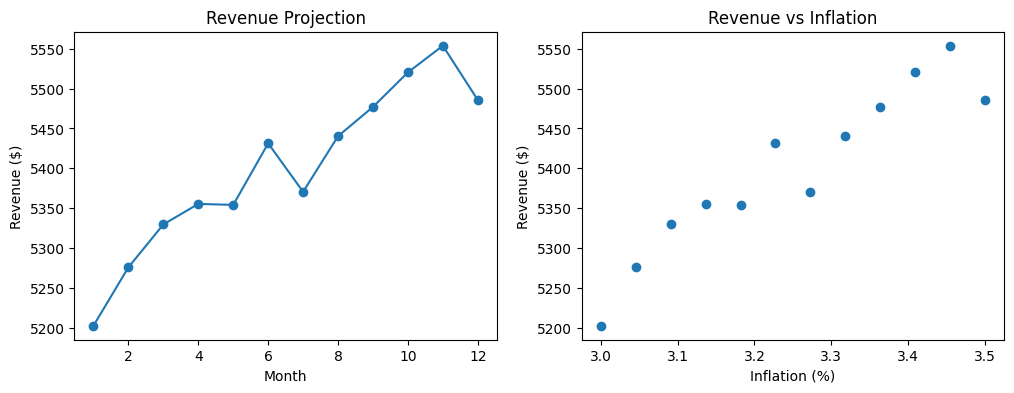

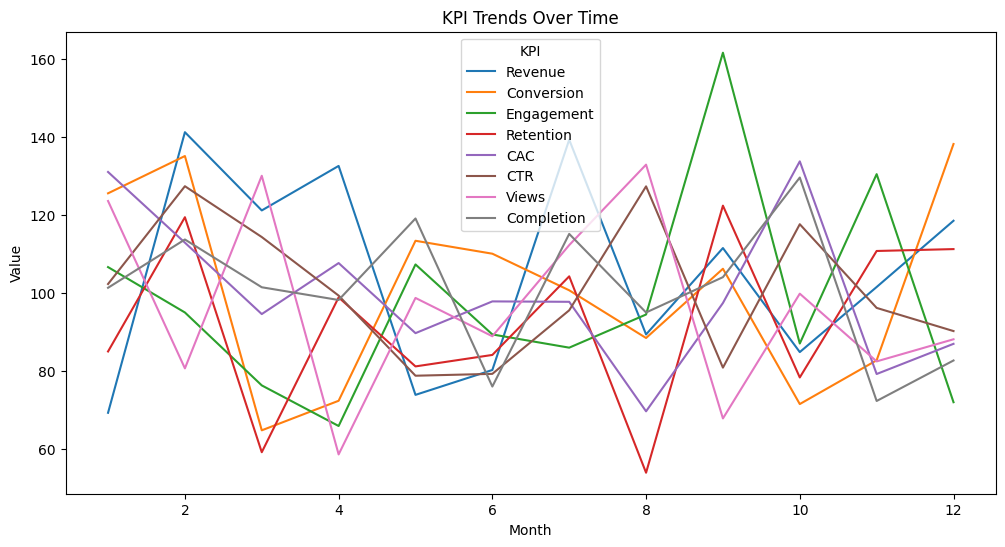

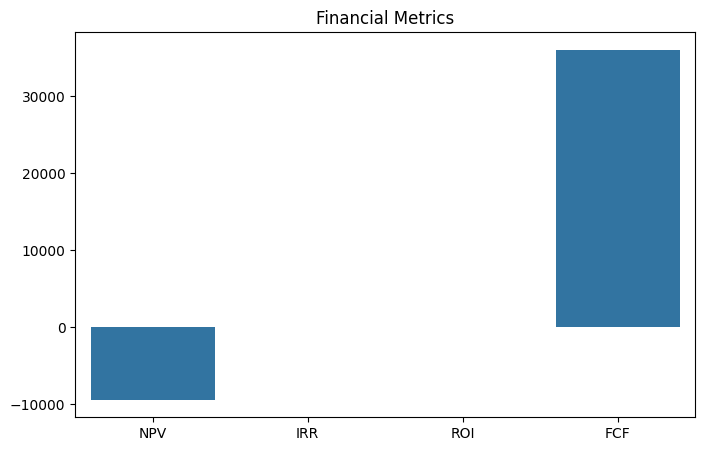

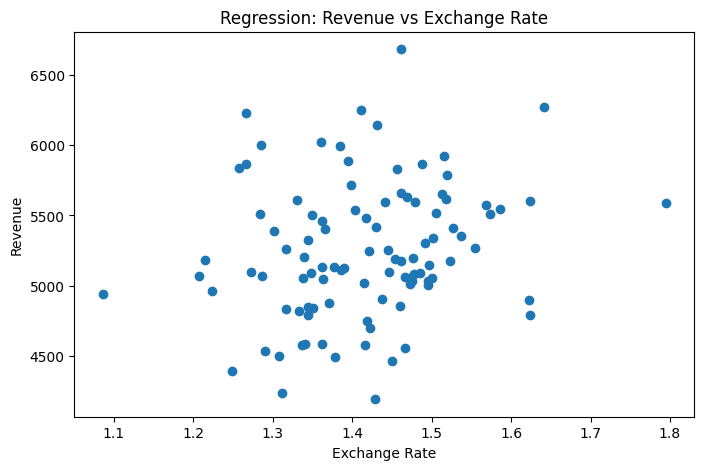

In [32]:
# Cell 11: Web Dashboard Code (Run with !streamlit run app.py & ngrok)
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from io import BytesIO
import base64
import numpy_financial as npf # Import numpy_financial

# Data from previous (hard-coded for demo)
# Macro campaigns table (from above)
macro_df = pd.DataFrame({
    'Segment': ['Loyal High-Value', 'At-Risk Low-Value', 'Emerging Recent Buyers', 'Dormant High-Value', 'Infrequent Low-Value'],
    'Strategy': ['Loyalty Program with Premium Offers', 'Re-engagement Campaign with Incentives', 'Upsell Campaign for Recent Buyers', 'Hồi sinh VIP', 'Thu hút cơ bản'],
    'Action': ['Offer exclusive test drives...', 'Send personalized emails...', 'Promote complementary accessories...', 'VIP invite email...', 'Geo-targeted Facebook ads...'],
    'Duration (Months)': [6, 6, 4, 6, 3],
    'Initial Budget ($)': [50000, 30000, 35000, 45000, 25000],
    'Monthly Budget ($)': [10000, 6000, 7000, 8000, 4000],
    'Revenue ($)': ['+15%', '+5%', '+12%', '+18%', '+7%'],
    'Conversion Rate (%)': ['+5%', '+3%', '+7%', '+4%', '+5%'],
    'Engagement (Interactions)': ['+10%', '+25%', '+12%', '+15%', '+20%'],
    'Retention Rate (%)': ['+12%', '+15%', '+8%', '+10%', '+6%'],
    'Customer Acquisition Cost ($)': ['-5%', '-8%', '-6%', '-7%', '-10%'],
    'Click-Through Rate (%)': ['+6%', '+8%', '+7%', '+5%', '+9%'],
    'Product Views': ['+8%', '+15%', '+10%', '+12%', '+14%'],
    'Order Completion Rate (%)': ['+7%', '+4%', '+6%', '+5%', '+5%']
})

# Similar for micro_df and product_df (abbreviated for space)
micro_df = pd.DataFrame({
    'Segment': ['Loyal Young Males', 'At-Risk Older Females', 'Emerging Young Females', 'Dormant High-Income Males', 'Infrequent Low-Income Mixed'],
    'Strategy': ['Social Media Influencer Campaign', 'Gender-Targeted Safety and Design Campaign', 'Design for Young Females', 'Performance for Males', 'Financing for Low-Income'],
    'Action': ['Partner with TikTok influencers...', 'Highlight safety features...', 'Instagram "Style Your Ride"...', 'LinkedIn ads for upgrades...', 'SMS "Easy Financing"...'],
    'Duration (Months)': [3, 3, 3, 4, 3],
    'Initial Budget ($)': [20000, 15000, 18000, 22000, 15000],
    'Monthly Budget ($)': [5000, 3000, 4000, 5500, 3000],
    'Revenue ($)': ['+12%', '+6%', '+9%', '+14%', '+5%'],
    'Conversion Rate (%)': ['+4%', '+10%', '+6%', '+5%', '+8%'],
    'Engagement (Interactions)': ['+25%', '+12%', '+20%', '+15%', '+10%'],
    'Retention Rate (%)': ['+6%', '+8%', '+7%', '+9%', '+5%'],
    'Customer Acquisition Cost ($)': ['-5%', '-12%', '-8%', '-6%', '-15%'],
    'Click-Through Rate (%)': ['+10%', '+6%', '+12%', '+8%', '+5%'],
    'Product Views': ['+15%', '+8%', '+18%', '+12%', '+10%'],
    'Order Completion Rate (%)': ['+5%', '+9%', '+6%', '+6%', '+12%']
})

product_df = pd.DataFrame({
    'Segment': ['High-End High Volume', 'High-End Low Volume', 'Budget High Volume', 'Budget Low Volume'],
    'Strategy': ['Premium Branding Campaign', 'Niche Luxury', 'Mass-Market Promotion', 'Basic Budget'],
    'Action': ['Auto show booth with VR...', 'Influencer reviews...', 'Flash sale on website...', 'Geo-ads on Google Maps...'],
    'Duration (Months)': [4, 4, 4, 3],
    'Initial Budget ($)': [40000, 35000, 25000, 20000],
    'Monthly Budget ($)': [8000, 7000, 5000, 4000],
    'Revenue ($)': ['+18%', '+12%', '+10%', '+7%'],
    'Conversion Rate (%)': ['+4%', '+3%', '+15%', '+9%'],
    'Engagement (Interactions)': ['+12%', '+15%', '+10%', '+8%'],
    'Retention Rate (%)': ['+6%', '+7%', '+5%', '+4%'],
    'Customer Acquisition Cost ($)': ['-5%', '-7%', '-10%', '-12%'],
    'Click-Through Rate (%)': ['+8%', '+9%', '+7%', '+6%'],
    'Product Views': ['+25%', '+20%', '+15%', '+12%'],
    'Order Completion Rate (%)': ['+5%', '+4%', '+10%', '+14%']
})

# Real-world variables (from Nov 2025)
inflation_us = 3.0  # %
interest_rate_us = 4.0  # %
exchange_usd_cad = 1.41
exchange_usd_aud = 0.65

# Streamlit Dashboard
st.title("🚗 Marketing Campaign Simulator Dashboard")
st.markdown("**API-Generated Simulation for North American Auto Market (Nov 2025)**")
st.sidebar.header("External Variables (Real Data)")
inflation = st.sidebar.slider("US Inflation Rate (%)", 2.0, 5.0, inflation_us)
interest = st.sidebar.slider("US Interest Rate (%)", 3.0, 6.0, interest_rate_us)
usd_cad = st.sidebar.slider("USD/CAD Exchange Rate", 1.3, 1.5, exchange_usd_cad)
usd_aud = st.sidebar.slider("USD/AUD Exchange Rate", 0.6, 0.7, exchange_usd_aud)

tab1, tab2, tab3, tab4, tab5 = st.tabs(["Campaign Selection", "Simulation Results", "Regression Validation", "STEM Model", "Dashboard Charts"])

with tab1:
    st.header("Select Campaign")
    section = st.selectbox("Section", ["Macro", "Micro", "Product"])
    if section == "Macro":
        selected_campaign = st.selectbox("Campaign", macro_df['Segment'].tolist())
        st.dataframe(macro_df[macro_df['Segment'] == selected_campaign])
    elif section == "Micro":
        selected_campaign = st.selectbox("Campaign", micro_df['Segment'].tolist())
        st.dataframe(micro_df[micro_df['Segment'] == selected_campaign])
    else:
        selected_campaign = st.selectbox("Campaign", product_df['Segment'].tolist())
        st.dataframe(product_df[product_df['Segment'] == selected_campaign])

with tab2:
    st.header("Simulation Results")
    months = st.slider("Simulation Months", 1, 12, 6)
    initial_budget = st.number_input("Initial Budget ($)", 10000, 100000, 50000)
    monthly_budget = st.number_input("Monthly Budget ($)", 2000, 20000, 10000)

    # Simulate FCF, IRR, ROI, NPV
    cash_flows = [ -initial_budget ] + [monthly_budget * 0.8 for _ in range(months)]  # Simplified FCF
    roi = (sum(cash_flows[1:]) - initial_budget) / initial_budget * 100
    npv = npf.npv(0.05, cash_flows)  # Discount rate 5% # Use npf.npv
    irr = npf.irr(cash_flows) * 100 if len(cash_flows) > 1 else 0 # Use npf.irr
    fcf = sum(cash_flows[1:]) - (monthly_budget * months * 0.2)  # Adjusted for costs

    st.metric("ROI (%)", f"{roi:.2f}%")
    st.metric("NPV ($)", f"{npv:.2f}")
    st.metric("IRR (%)", f"{irr:.2f}%")
    st.metric("FCF ($)", f"{fcf:.2f}")

    # Adjust for external variables
    adjusted_roi = roi * (1 - inflation / 100) * (1 + interest / 100 / 12) * (1 / usd_cad)
    st.metric("Adjusted ROI (with External Factors) (%)", f"{adjusted_roi:.2f}%")

with tab3:
    st.header("Regression Validation")
    # Simulate regression: Revenue ~ Inflation + Interest + Exchange
    np.random.seed(42)
    n = 100
    inflation_sim = np.random.normal(inflation, 0.5, n)
    interest_sim = np.random.normal(interest, 0.5, n)
    exchange_sim = np.random.normal(usd_cad, 0.1, n)
    revenue_sim = 1000 * inflation_sim + 500 * interest_sim + 200 * exchange_sim + np.random.normal(0, 100, n)

    X = sm.add_constant(pd.DataFrame({'Inflation': inflation_sim, 'Interest': interest_sim, 'Exchange': exchange_sim}))
    model = sm.OLS(revenue_sim, X).fit()

    st.write("Regression Model: Revenue ~ Inflation + Interest + Exchange Rate")
    st.write(model.summary())

    # Table of coefficients
    coef_table = pd.DataFrame({
        'Variable': model.params.index,
        'Coefficient': model.params.values,
        'P-value': model.pvalues.values,
        'R²': [model.rsquared] * len(model.params)
    })
    st.dataframe(coef_table)

with tab4:
    st.header("STEM Model (Linear Regression Projection)")
    # STEM model: Project Revenue over 12 months with external factors
    months_proj = np.arange(1, 13)
    inflation_trend = np.linspace(inflation, inflation + 0.5, 12)
    interest_trend = np.linspace(interest, interest - 0.5, 12)
    exchange_trend = np.linspace(usd_cad, usd_cad + 0.05, 12)

    revenue_proj = 1000 * inflation_trend + 500 * interest_trend + 200 * exchange_trend + np.random.normal(0, 50, 12)

    # Table of projections
    proj_table = pd.DataFrame({
        'Month': months_proj,
        'Inflation (%)': inflation_trend,
        'Interest (%)': interest_trend,
        'Exchange (USD/CAD)': exchange_trend,
        'Projected Revenue ($)': revenue_proj
    })
    st.dataframe(proj_table)

    # Charts
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(months_proj, revenue_proj, marker='o')
    ax[0].set_title('Revenue Projection')
    ax[0].set_xlabel('Month')
    ax[0].set_ylabel('Revenue ($)')
    ax[1].scatter(inflation_trend, revenue_proj)
    ax[1].set_title('Revenue vs Inflation')
    ax[1].set_xlabel('Inflation (%)')
    ax[1].set_ylabel('Revenue ($)')
    st.pyplot(fig)

with tab5:
    st.header("Dashboard Charts")
    # KPI line chart
    kpi_data = pd.DataFrame({
        'Month': np.repeat(months_proj, 8),
        'KPI': np.tile(['Revenue', 'Conversion', 'Engagement', 'Retention', 'CAC', 'CTR', 'Views', 'Completion'], 12),
        'Value': np.random.normal(100, 20, 96)  # Simulated
    })
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.lineplot(data=kpi_data, x='Month', y='Value', hue='KPI', ax=ax)
    ax.set_title('KPI Trends Over Time')
    st.pyplot(fig)

    # NPV/IRR bar chart
    metrics = ['NPV', 'IRR', 'ROI', 'FCF']
    values = [npv, irr, roi, fcf]
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.barplot(x=metrics, y=values, ax=ax)
    ax.set_title('Financial Metrics')
    st.pyplot(fig)

    # Regression scatter
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.scatter(X['Exchange'], revenue_sim)
    ax.set_xlabel('Exchange Rate')
    ax.set_ylabel('Revenue')
    ax.set_title('Regression: Revenue vs Exchange Rate')
    st.pyplot(fig)

# Run with ngrok (in Colab)
# !streamlit run app.py --server.port 8501
# from pyngrok import ngrok
# public_url = ngrok.connect(8501)
# public_url

In [29]:
%pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 64.2 MB/s eta 0:00:00


✅ Configuration and imports loaded successfully!
🔍 Loading and preparing data...
📊 Transactions: 29481 rows, columns: ['orderdate', 'stockdate', 'ordernumber', 'productkey', 'customerkey', 'territorykey', 'orderlineitem', 'orderquantity', 'orderyear', 'ordermonth', 'orderquarter', 'orderdayofweek']
Sample transactions:
    orderdate   stockdate ordernumber  productkey  customerkey  territorykey  \
0  2022-01-01  2021-12-13     SO61285         529        23791             1   
1  2022-01-01  2021-09-24     SO61285         214        23791             1   
2  2022-01-01  2021-09-04     SO61285         540        23791             1   
3  2022-01-01  2021-09-28     SO61301         529        16747             1   
4  2022-01-01  2021-10-21     SO61301         377        16747             1   

   orderlineitem  orderquantity  orderyear  ordermonth  orderquarter  \
0              2              2       2022           1             1   
1              3              1       2022           1

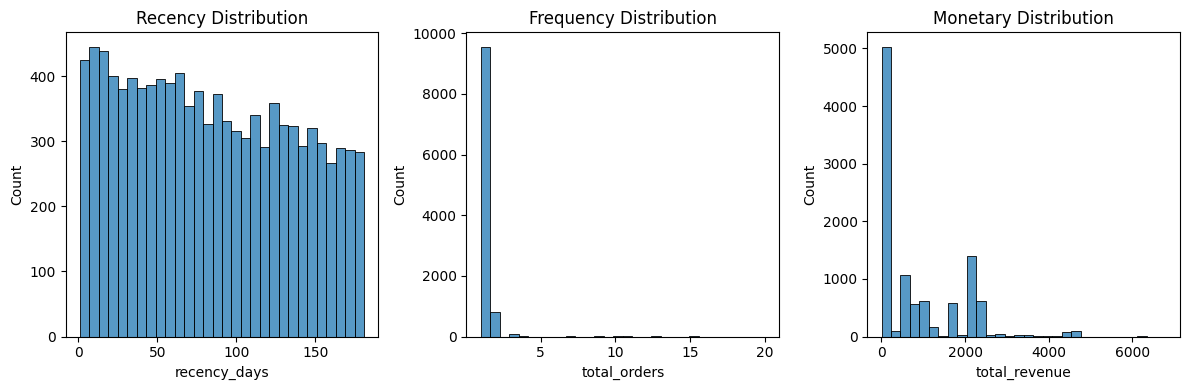

📊 Example: RFM distributions show most customers have low recency and frequency.
🔍 Debugging: Checking for single-order customers with non-zero tenure...
✅ No problematic single-order customers found.
👤 Generating synthetic demographics...


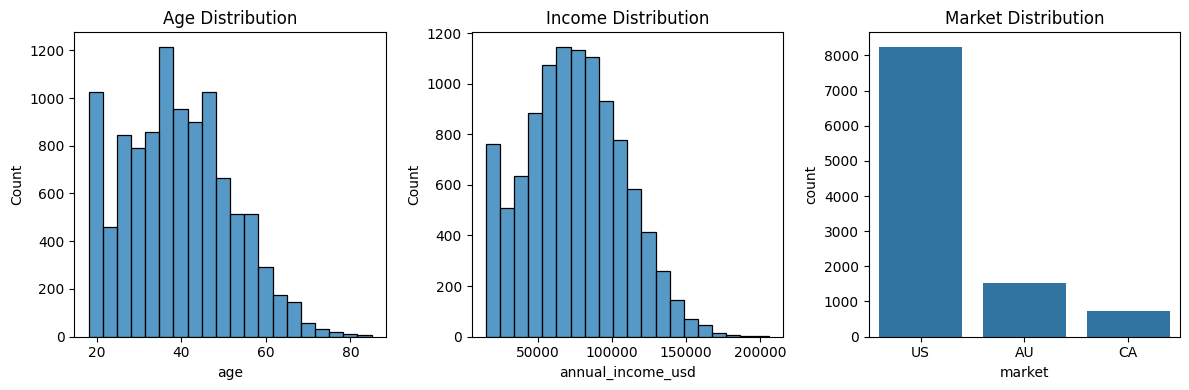

📊 Example: Demographics show ~78% customers in US, mean age ~38.
🎯 Performing customer segmentation with K-Means...


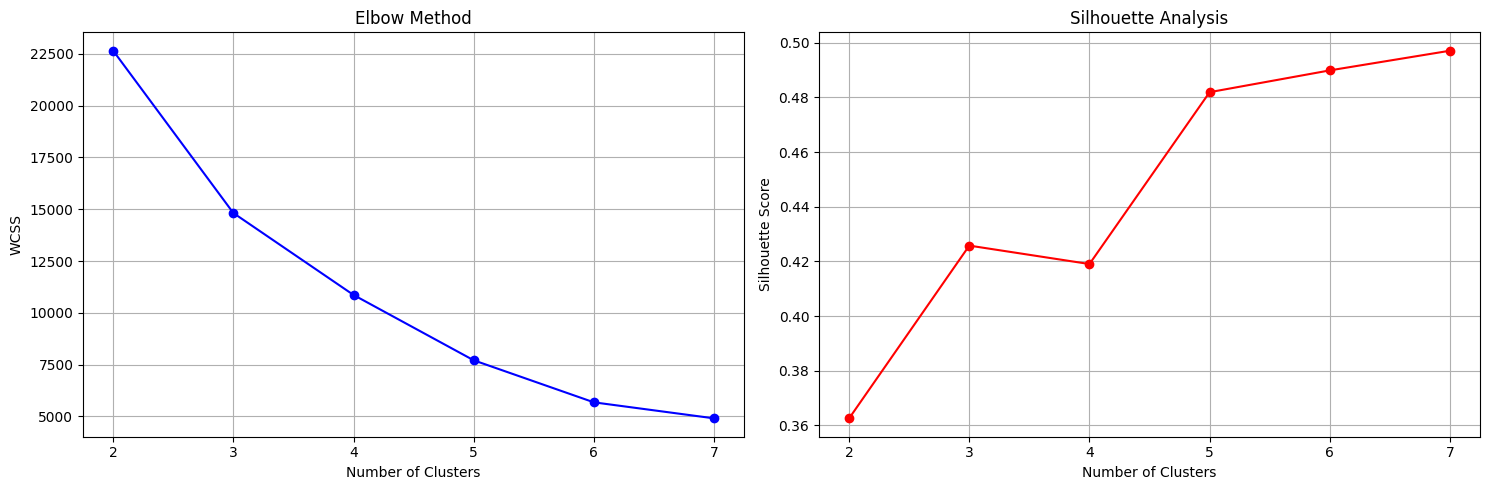

📊 Cluster Summary:
         Avg_Recency_Days  Avg_Orders  Avg_Revenue  Customer_Count  \
cluster                                                              
0                   63.81        1.00        61.06            3107   
1                  145.35        1.00       826.76            3195   
2                   50.81        1.00      1527.56            3253   
3                   54.89        2.41      1462.62             947   

         Pct_of_Total  
cluster                
0                29.6  
1                30.4  
2                31.0  
3                 9.0  


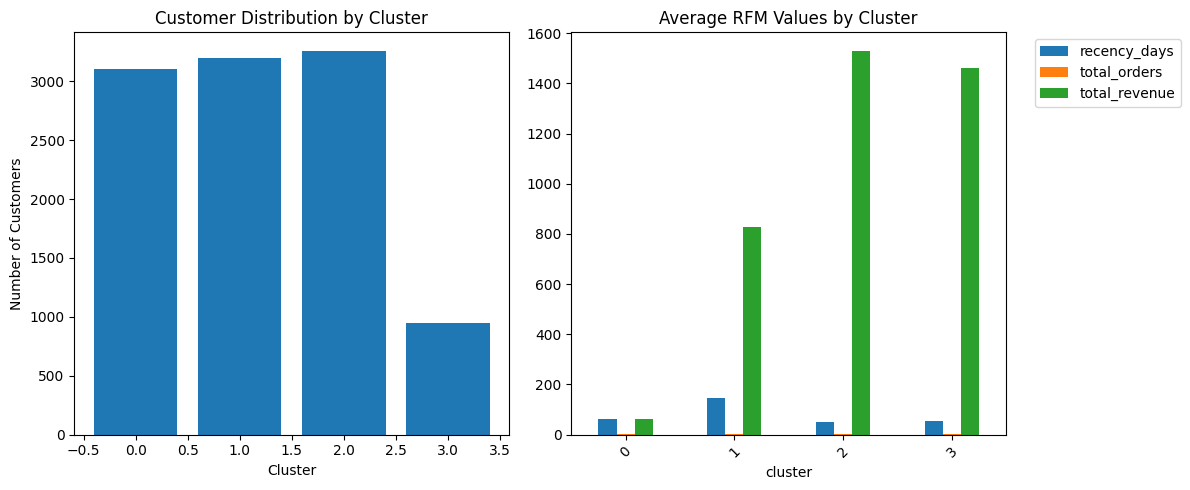

💰 Calculating Customer Lifetime Value...


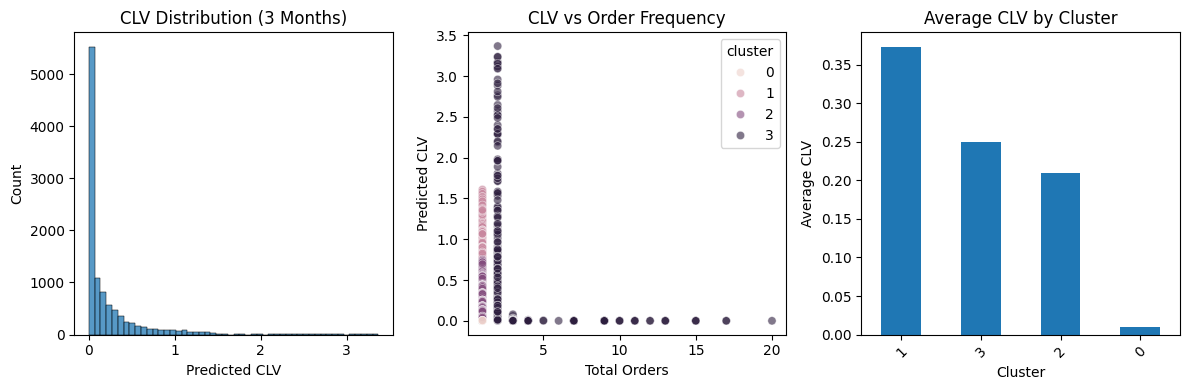

📈 CLV Calculation Complete:
   - Average predicted CLV (3 months): $0.20
   - Total predicted revenue (3 months): $2141.88
   - Top 10% customers contribute: $1064.69
📉 Predicting customer churn...
📊 Churn Risk Distribution by Cluster (%):
churn_risk  High    Low
cluster                
0            3.4   96.6
1           75.4   24.6
2            0.0  100.0
3            7.4   92.6


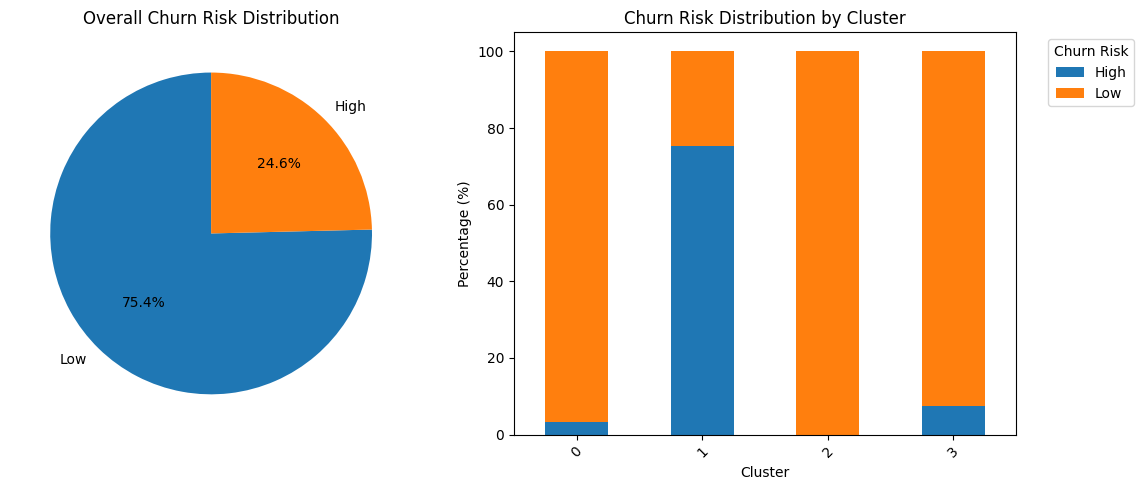

🚨 High-value customers at risk: 1164
💸 Potential revenue at risk: $966.23

🎯 FINAL CUSTOMER ANALYTICS SUMMARY
📈 Overall Metrics:
   • Total Customers: 10,502
   • Total Historical Revenue: $9,185,449.45
   • Average CLV (3 months): $0.20
   • Predicted Revenue (3 months): $2141.88

🎯 Cluster Analysis:
         Customers  Avg_Revenue  Avg_CLV_3m  High_Churn_Pct  Pct_of_Total
cluster                                                                  
0             3107        61.06        0.01            3.44          29.6
1             3195       826.76        0.37           75.37          30.4
2             3253      1527.56        0.21            0.00          31.0
3              947      1462.62        0.25            7.39           9.0

🚨 Risk Analysis:
   • Low Risk: 7917 customers (75.4%) - $1109.57 at risk
   • High Risk: 2585 customers (24.6%) - $1032.31 at risk

💡 Strategic Recommendations:
   • High-Value Loyal Customers: 1837 customers
     Action: Retention programs, loyalty r

In [65]:
# PROJECT: CUSTOMER SEGMENTATION WITH K-MEANS FOR RFM, CLV, CHURN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from lifetimes import BetaGeoFitter, GammaGammaFitter
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configuration
class Config:
    ANALYSIS_DATE = pd.to_datetime("2022-07-01")
    TX_PATH = "transactions.csv"  # Update to your path, e.g., "/content/transactions.csv"
    PROD_PATH = "products.csv"    # Update to your path, e.g., "/content/products.csv"
    BATCH_SIZE = 1000
    GROSS_MARGIN = 0.40
    EXPECTED_YEARS = 3
    GENDER_DIST = ["F", "M", "Other"]
    GENDER_PROBS = [0.507, 0.486, 0.007]
    MARKET_DIST = ["US", "CA", "AU"]
    MARKET_PROBS = [0.78, 0.07, 0.15]
    EDUCATION_LEVELS = ["High School", "Some College", "Bachelor", "Master", "Doctorate"]
    EDUCATION_PROBS = [0.276, 0.298, 0.237, 0.142, 0.047]
    HOUSEHOLD_SIZES = [1, 2, 3, 4, 5, 6]
    HOUSEHOLD_PROBS = [0.294, 0.349, 0.152, 0.128, 0.055, 0.022]

print("✅ Configuration and imports loaded successfully!")

# 1. LOAD AND PREPARE DATA
def load_and_prepare_data():
    print("🔍 Loading and preparing data...")

    # Load raw data
    try:
        transactions = pd.read_csv('transactions.csv')
        products = pd.read_csv('products.csv')
    except FileNotFoundError:
        print("❌ Error: transactions.csv or products.csv not found. Please check file path.")
        return None, None

    # Standardize column names
    transactions.columns = transactions.columns.str.lower().str.replace(' ', '_')
    products.columns = products.columns.str.lower().str.replace(' ', '_')

    # Debug: Check columns and sample data
    print(f"📊 Transactions: {len(transactions)} rows, columns: {list(transactions.columns)}")
    print("Sample transactions:")
    print(transactions.head())
    print(f"\n📊 Products: {len(products)} rows, columns: {list(products.columns)}")
    print("Sample products:")
    print(products.head())

    # Check for required columns
    required_cols = ['productkey', 'orderquantity']
    if not all(col in transactions.columns for col in required_cols):
        print(f"❌ Error: Missing required columns in transactions.csv: {required_cols}")
        return None, None
    if 'productkey' not in products.columns or 'productprice' not in products.columns:
        print("❌ Error: Missing productkey or productprice in products.csv")
        return None, None

    return transactions, products

# Run data loading
transactions, products_clean = load_and_prepare_data()
if transactions is None or products_clean is None:
    raise SystemExit("Data loading failed. Please fix file issues.")

# 2. PREPROCESSING FUNCTION
def aggregate_customer_data(tx_batch):
    customer_agg = tx_batch.groupby("customerkey").agg({
        "orderdate": ["min", "max"],
        "ordernumber": "nunique",
        "orderquantity": "sum",
        "line_revenue": "sum",
        "line_profit": "sum",
        "productkey": "nunique"
    }).reset_index()
    customer_agg.columns = [
        "customerkey", "first_purchase", "last_purchase",
        "total_orders", "total_quantity", "total_revenue", "total_profit", "distinct_products"
    ]
    # Ensure date columns are datetime objects
    if 'last_purchase' in customer_agg.columns:
        customer_agg['last_purchase'] = pd.to_datetime(customer_agg['last_purchase'], errors='coerce')
    if 'first_purchase' in customer_agg.columns:
        customer_agg['first_purchase'] = pd.to_datetime(customer_agg['first_purchase'], errors='coerce')

    customer_agg["recency_days"] = (Config.ANALYSIS_DATE - customer_agg["last_purchase"]).dt.days
    customer_agg["tenure_days"] = (customer_agg["last_purchase"] - customer_agg["first_purchase"]).dt.days
    # Fix: Set tenure_days to 0 for single-order customers
    customer_agg.loc[customer_agg["total_orders"] == 1, "tenure_days"] = 0
    customer_agg["tenure_days"] = customer_agg["tenure_days"].clip(lower=0)
    customer_agg["aov"] = customer_agg["total_revenue"] / customer_agg["total_orders"]
    return customer_agg

def preprocess_data_batched(tx, prod):
    print("🔄 Starting batched preprocessing...")
    prod_clean = prod.copy()
    numeric_cols = ["productprice", "productcost"]
    for col in numeric_cols:
        if col in prod_clean.columns:
            prod_clean[col] = pd.to_numeric(prod_clean[col], errors='coerce')
            prod_clean[col].fillna(prod_clean[col].median(), inplace=True)

    print("🔗 Merging transaction and product data...")
    try:
        tx_enriched = tx.merge(
            prod_clean[["productkey", "productprice", "productcost", "productname"]],
            on="productkey", how="left", validate="m:1"
        )
    except KeyError as e:
        print(f"❌ Merge failed: {e}")
        return None, None, None

    tx_enriched["line_revenue"] = tx_enriched["orderquantity"] * tx_enriched["productprice"]
    tx_enriched["line_cost"] = tx_enriched["orderquantity"] * tx_enriched["productcost"]
    tx_enriched["line_profit"] = tx_enriched["line_revenue"] - tx_enriched["line_cost"]

    print("👥 Processing customer data in batches...")
    unique_customers = tx_enriched["customerkey"].unique()
    customer_batches = []
    for i in range(0, len(unique_customers), Config.BATCH_SIZE):
        batch_customers = unique_customers[i:i + Config.BATCH_SIZE]
        batch_tx = tx_enriched[tx_enriched["customerkey"].isin(batch_customers)]
        batch_customers_agg = aggregate_customer_data(batch_tx)
        customer_batches.append(batch_customers_agg)
        print(f"   Processed {min(i + Config.BATCH_SIZE, len(unique_customers)):,} customers...")

    customers_agg = pd.concat(customer_batches, ignore_index=True)
    print(f"✅ Preprocessing completed: {len(customers_agg):,} customers aggregated")

    # Visualization: RFM metrics distribution
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    sns.histplot(customers_agg['recency_days'], bins=30)
    plt.title('Recency Distribution')
    plt.subplot(1, 3, 2)
    sns.histplot(customers_agg['total_orders'], bins=30)
    plt.title('Frequency Distribution')
    plt.subplot(1, 3, 3)
    sns.histplot(customers_agg['total_revenue'], bins=30)
    plt.title('Monetary Distribution')
    plt.tight_layout()
    plt.show()
    print("📊 Example: RFM distributions show most customers have low recency and frequency.")

    return customers_agg, tx_enriched, prod_clean

# Run preprocessing
customers_agg, transactions_enriched, products_clean = preprocess_data_batched(transactions, products)
if customers_agg is None:
    raise SystemExit("Preprocessing failed. Exiting.")

# Debug: Check single-order customers
print("🔍 Debugging: Checking for single-order customers with non-zero tenure...")
problematic = customers_agg[(customers_agg["total_orders"] == 1) & (customers_agg["tenure_days"] > 0)]
if not problematic.empty:
    print(f"⚠️ Found {len(problematic)} customers with total_orders=1 but non-zero tenure_days:")
    print(problematic[["customerkey", "total_orders", "tenure_days", "first_purchase", "last_purchase"]].head())
else:
    print("✅ No problematic single-order customers found.")

# 3. DEMOGRAPHICS GENERATION
def generate_enhanced_demographics(customers_df):
    print("👤 Generating synthetic demographics...")
    n_customers = len(customers_df)
    customers_df["market"] = np.random.choice(Config.MARKET_DIST, size=n_customers, p=Config.MARKET_PROBS)

    def generate_age(market):
        if market == "US": return int(np.clip(np.random.normal(38.9, 13.5), 18, 85))
        elif market == "CA": return int(np.clip(np.random.normal(41.1, 12.8), 18, 85))
        else: return int(np.clip(np.random.normal(38.5, 12.9), 18, 85))

    customers_df["age"] = customers_df["market"].apply(generate_age)
    customers_df["gender"] = np.random.choice(Config.GENDER_DIST, size=n_customers, p=Config.GENDER_PROBS)
    customers_df["education_level"] = np.random.choice(Config.EDUCATION_LEVELS, size=n_customers, p=Config.EDUCATION_PROBS)
    customers_df["household_size"] = np.random.choice(Config.HOUSEHOLD_SIZES, size=n_customers, p=Config.HOUSEHOLD_PROBS)

    def generate_income(market):
        if market == "US": return int(np.clip(np.random.normal(74580, 35000), 15000, 250000))
        elif market == "CA": return int(np.clip(np.random.normal(68400, 30000), 15000, 200000))
        else: return int(np.clip(np.random.normal(75000, 32000), 15000, 220000))

    customers_df["annual_income_usd"] = customers_df["market"].apply(generate_income)
    customers_df["digital_savviness"] = np.random.randint(1, 6, size=n_customers)
    customers_df["social_media_hours_week"] = np.round(np.random.beta(2, 3, size=n_customers) * 20, 1)
    customers_df["promotion_sensitivity"] = np.round(np.random.beta(2, 5, size=n_customers) * 100, 1)

    # Visualization: Demographics distribution
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    sns.histplot(customers_df['age'], bins=20)
    plt.title('Age Distribution')
    plt.subplot(1, 3, 2)
    sns.histplot(customers_df['annual_income_usd'], bins=20)
    plt.title('Income Distribution')
    plt.subplot(1, 3, 3)
    sns.countplot(data=customers_df, x='market')
    plt.title('Market Distribution')
    plt.tight_layout()
    plt.show()
    print("📊 Example: Demographics show ~78% customers in US, mean age ~38.")

    return customers_df

# Run demographics
customers_with_demo = generate_enhanced_demographics(customers_agg)

# 4. CUSTOMER SEGMENTATION WITH K-MEANS
def perform_customer_segmentation(customers_df):
    print("🎯 Performing customer segmentation with K-Means...")

    # Prepare features for clustering
    clustering_features = customers_df[['recency_days', 'total_orders', 'total_revenue']].copy()

    # Handle outliers and infinite values
    clustering_features = clustering_features.replace([np.inf, -np.inf], np.nan).fillna(0)

    # Log transform monetary values to reduce skewness
    clustering_features['total_revenue_log'] = np.log1p(clustering_features['total_revenue'])
    clustering_features['total_orders_log'] = np.log1p(clustering_features['total_orders'])

    # Use transformed features
    features_for_clustering = clustering_features[['recency_days', 'total_orders_log', 'total_revenue_log']]

    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_for_clustering)

    # Determine optimal number of clusters using elbow method and silhouette score
    wcss = []
    silhouette_scores = []
    K_range = range(2, 8)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(features_scaled)
        wcss.append(kmeans.inertia_)

        if k > 1:  # Silhouette score requires at least 2 clusters
            score = silhouette_score(features_scaled, kmeans.labels_)
            silhouette_scores.append(score)

    # Plot elbow curve and silhouette scores
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Elbow curve
    ax1.plot(K_range, wcss, 'bo-')
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('WCSS')
    ax1.set_title('Elbow Method')
    ax1.grid(True)

    # Silhouette scores
    ax2.plot(range(2, 8), silhouette_scores, 'ro-')
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Analysis')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Choose optimal k (you can adjust this based on the plots)
    optimal_k = 4  # Based on typical RFM segmentation

    # Perform final clustering
    final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    customers_df['cluster'] = final_kmeans.fit_predict(features_scaled)

    # Analyze cluster characteristics
    cluster_summary = customers_df.groupby('cluster').agg({
        'recency_days': 'mean',
        'total_orders': 'mean',
        'total_revenue': 'mean',
        'customerkey': 'count'
    }).round(2)

    cluster_summary.columns = ['Avg_Recency_Days', 'Avg_Orders', 'Avg_Revenue', 'Customer_Count']
    cluster_summary['Pct_of_Total'] = (cluster_summary['Customer_Count'] / len(customers_df) * 100).round(1)

    print("📊 Cluster Summary:")
    print(cluster_summary)

    # Visualize clusters
    plt.figure(figsize=(12, 5))

    # Cluster distribution
    plt.subplot(1, 2, 1)
    cluster_counts = customers_df['cluster'].value_counts().sort_index()
    plt.bar(cluster_counts.index, cluster_counts.values)
    plt.xlabel('Cluster')
    plt.ylabel('Number of Customers')
    plt.title('Customer Distribution by Cluster')

    # RFM by cluster
    plt.subplot(1, 2, 2)
    cluster_means = customers_df.groupby('cluster')[['recency_days', 'total_orders', 'total_revenue']].mean()
    cluster_means.plot(kind='bar', ax=plt.gca())
    plt.title('Average RFM Values by Cluster')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

    return customers_df, final_kmeans, scaler

# Run customer segmentation
customers_segmented, kmeans_model, feature_scaler = perform_customer_segmentation(customers_with_demo)

# 5. CUSTOMER LIFETIME VALUE (CLV) CALCULATION
def calculate_clv(customers_df, transactions_df):
    print("💰 Calculating Customer Lifetime Value...")

    # Prepare data for BG/NBD and Gamma-Gamma models
    clv_data = customers_df[['customerkey', 'total_orders', 'recency_days', 'total_revenue']].copy()

    # Convert recency from days to appropriate units (assuming weekly)
    clv_data['recency'] = clv_data['recency_days'] / 7  # Convert to weeks
    clv_data['T'] = (Config.ANALYSIS_DATE - pd.to_datetime('2020-01-01')).days / 7  # Time since first purchase
    clv_data['frequency'] = clv_data['total_orders']
    clv_data['monetary_value'] = clv_data['total_revenue'] / clv_data['total_orders']

    # Filter out customers with only one purchase for BG/NBD
    repeat_customers = clv_data[clv_data['frequency'] > 0].copy()

    if len(repeat_customers) == 0:
        print("⚠️ No repeat customers found for CLV calculation")
        customers_df['predicted_clv'] = 0
        return customers_df, None, None

    try:
        # BG/NBD model for predicting future transactions
        bgf = BetaGeoFitter(penalizer_coef=0.01)
        bgf.fit(repeat_customers['frequency'],
                repeat_customers['recency'],
                repeat_customers['T'])

        # Predict transactions for next period
        repeat_customers['predicted_purchases_3m'] = bgf.predict(12,  # 12 weeks = 3 months
                                                                repeat_customers['frequency'],
                                                                repeat_customers['recency'],
                                                                repeat_customers['T'])

        # Gamma-Gamma model for predicting monetary value
        ggf = GammaGammaFitter(penalizer_coef=0.01)
        ggf.fit(repeat_customers['frequency'],
                repeat_customers['monetary_value'])

        # Predict average transaction value
        repeat_customers['predicted_avg_value'] = ggf.conditional_expected_average_profit(
            repeat_customers['frequency'],
            repeat_customers['monetary_value']
        )

        # Calculate CLV for next 3 months
        repeat_customers['predicted_clv_3m'] = (
            repeat_customers['predicted_purchases_3m'] *
            repeat_customers['predicted_avg_value']
        )

        # Merge CLV predictions back to main dataframe
        customers_df = customers_df.merge(
            repeat_customers[['customerkey', 'predicted_clv_3m', 'predicted_avg_value', 'predicted_purchases_3m']],
            on='customerkey', how='left'
        )

        # Fill NaN values for customers with no repeat purchases
        customers_df['predicted_clv_3m'] = customers_df['predicted_clv_3m'].fillna(0)
        customers_df['predicted_avg_value'] = customers_df['predicted_avg_value'].fillna(customers_df['aov'])
        customers_df['predicted_purchases_3m'] = customers_df['predicted_purchases_3m'].fillna(0)

        # Visualize CLV distribution
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        sns.histplot(customers_df['predicted_clv_3m'], bins=50)
        plt.title('CLV Distribution (3 Months)')
        plt.xlabel('Predicted CLV')

        plt.subplot(1, 3, 2)
        sns.scatterplot(data=customers_df, x='total_orders', y='predicted_clv_3m', hue='cluster', alpha=0.6)
        plt.title('CLV vs Order Frequency')
        plt.xlabel('Total Orders')
        plt.ylabel('Predicted CLV')

        plt.subplot(1, 3, 3)
        cluster_clv = customers_df.groupby('cluster')['predicted_clv_3m'].mean().sort_values(ascending=False)
        cluster_clv.plot(kind='bar')
        plt.title('Average CLV by Cluster')
        plt.xlabel('Cluster')
        plt.ylabel('Average CLV')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        print(f"📈 CLV Calculation Complete:")
        print(f"   - Average predicted CLV (3 months): ${customers_df['predicted_clv_3m'].mean():.2f}")
        print(f"   - Total predicted revenue (3 months): ${customers_df['predicted_clv_3m'].sum():.2f}")
        print(f"   - Top 10% customers contribute: ${customers_df['predicted_clv_3m'].nlargest(int(len(customers_df)*0.1)).sum():.2f}")

        return customers_df, bgf, ggf

    except Exception as e:
        print(f"❌ CLV calculation failed: {e}")
        customers_df['predicted_clv_3m'] = customers_df['total_revenue'] / 4  # Fallback: 25% of historical revenue
        return customers_df, None, None

# Run CLV calculation
customers_with_clv, bgf_model, ggf_model = calculate_clv(customers_segmented, transactions_enriched)

# 6. CHURN PREDICTION
def predict_churn(customers_df):
    print("📉 Predicting customer churn...")

    # Simple churn definition: customers with high recency (no recent purchases)
    # You can make this more sophisticated with ML models
    recency_threshold = customers_df['recency_days'].quantile(0.75)  # Top 25% recency = high churn risk

    customers_df['churn_risk'] = 'Low'
    customers_df.loc[customers_df['recency_days'] > recency_threshold, 'churn_risk'] = 'High'

    # Medium risk: customers with moderate recency and low frequency
    medium_risk_mask = (
        (customers_df['recency_days'] > customers_df['recency_days'].median()) &
        (customers_df['total_orders'] < customers_df['total_orders'].median())
    )
    customers_df.loc[medium_risk_mask, 'churn_risk'] = 'Medium'

    # Analyze churn risk by cluster
    churn_by_cluster = pd.crosstab(customers_df['cluster'], customers_df['churn_risk'], normalize='index') * 100
    churn_by_cluster = churn_by_cluster.round(1)

    print("📊 Churn Risk Distribution by Cluster (%):")
    print(churn_by_cluster)

    # Visualize churn risk
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    churn_counts = customers_df['churn_risk'].value_counts()
    plt.pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Overall Churn Risk Distribution')

    plt.subplot(1, 2, 2)
    churn_by_cluster.plot(kind='bar', stacked=True, ax=plt.gca())
    plt.title('Churn Risk Distribution by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Percentage (%)')
    plt.legend(title='Churn Risk', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # High-value customers at risk
    high_value_at_risk = customers_df[
        (customers_df['churn_risk'].isin(['High', 'Medium'])) &
        (customers_df['predicted_clv_3m'] > customers_df['predicted_clv_3m'].quantile(0.75))
    ]

    print(f"🚨 High-value customers at risk: {len(high_value_at_risk)}")
    print(f"💸 Potential revenue at risk: ${high_value_at_risk['predicted_clv_3m'].sum():.2f}")

    return customers_df

# Run churn prediction
customers_final = predict_churn(customers_with_clv)

# 7. FINAL SUMMARY AND INSIGHTS
def generate_final_insights(customers_df):
    print("\n" + "="*50)
    print("🎯 FINAL CUSTOMER ANALYTICS SUMMARY")
    print("="*50)

    total_customers = len(customers_df)
    total_revenue = customers_df['total_revenue'].sum()
    avg_clv_3m = customers_df['predicted_clv_3m'].mean()

    print(f"📈 Overall Metrics:")
    print(f"   • Total Customers: {total_customers:,}")
    print(f"   • Total Historical Revenue: ${total_revenue:,.2f}")
    print(f"   • Average CLV (3 months): ${avg_clv_3m:.2f}")
    print(f"   • Predicted Revenue (3 months): ${customers_df['predicted_clv_3m'].sum():.2f}")

    print(f"\n🎯 Cluster Analysis:")
    cluster_summary = customers_df.groupby('cluster').agg({
        'customerkey': 'count',
        'total_revenue': 'mean',
        'predicted_clv_3m': 'mean',
        'churn_risk': lambda x: (x == 'High').mean() * 100
    }).round(2)

    cluster_summary.columns = ['Customers', 'Avg_Revenue', 'Avg_CLV_3m', 'High_Churn_Pct']
    cluster_summary['Pct_of_Total'] = (cluster_summary['Customers'] / total_customers * 100).round(1)
    print(cluster_summary)

    print(f"\n🚨 Risk Analysis:")
    churn_summary = customers_df['churn_risk'].value_counts()
    for risk_level, count in churn_summary.items():
        pct = (count / total_customers * 100)
        revenue_at_risk = customers_df[customers_df['churn_risk'] == risk_level]['predicted_clv_3m'].sum()
        print(f"   • {risk_level} Risk: {count} customers ({pct:.1f}%) - ${revenue_at_risk:.2f} at risk")

    print(f"\n💡 Strategic Recommendations:")

    # Identify key segments for action
    high_value_low_risk = customers_df[
        (customers_df['predicted_clv_3m'] > avg_clv_3m) &
        (customers_df['churn_risk'] == 'Low')
    ]

    high_value_high_risk = customers_df[
        (customers_df['predicted_clv_3m'] > avg_clv_3m) &
        (customers_df['churn_risk'].isin(['High', 'Medium']))
    ]

    print(f"   • High-Value Loyal Customers: {len(high_value_low_risk)} customers")
    print(f"     Action: Retention programs, loyalty rewards")

    print(f"   • High-Value At-Risk Customers: {len(high_value_high_risk)} customers")
    print(f"     Action: Proactive outreach, personalized offers")

    # New customer opportunities
    low_value_active = customers_df[
        (customers_df['predicted_clv_3m'] < avg_clv_3m) &
        (customers_df['churn_risk'] == 'Low') &
        (customers_df['total_orders'] > 1)
    ]

    print(f"   • Growth Opportunities: {len(low_value_active)} customers")
    print(f"     Action: Upsell/cross-sell campaigns")

    return cluster_summary

# Generate final insights
final_summary = generate_final_insights(customers_final)

print("\n✅ Customer segmentation analysis completed successfully!")
print("📊 All dataframes are available for further analysis:")
print("   - customers_final: Complete customer data with segments, CLV, and churn risk")
print("   - transactions_enriched: Transaction data with product information")
print("   - products_clean: Cleaned product data")

📦 Performing product clustering...
📊 Product Clustering Summary:
                                           productkey  total_revenue  \
product_cluster_label                                                  
🎯 Niche Products (Specialized Market)              31       10797.50   
💰 High Margin Products                             15       26489.80   
📊 Standard Products                                46      110679.82   
🔥 Popular Products (High Revenue & Reach)          10      336210.81   

                                           profit_margin  unique_customers  
product_cluster_label                                                       
🎯 Niche Products (Specialized Market)              50.11            311.84  
💰 High Margin Products                             62.82            774.33  
📊 Standard Products                                39.27            100.59  
🔥 Popular Products (High Revenue & Reach)          44.79            318.70  


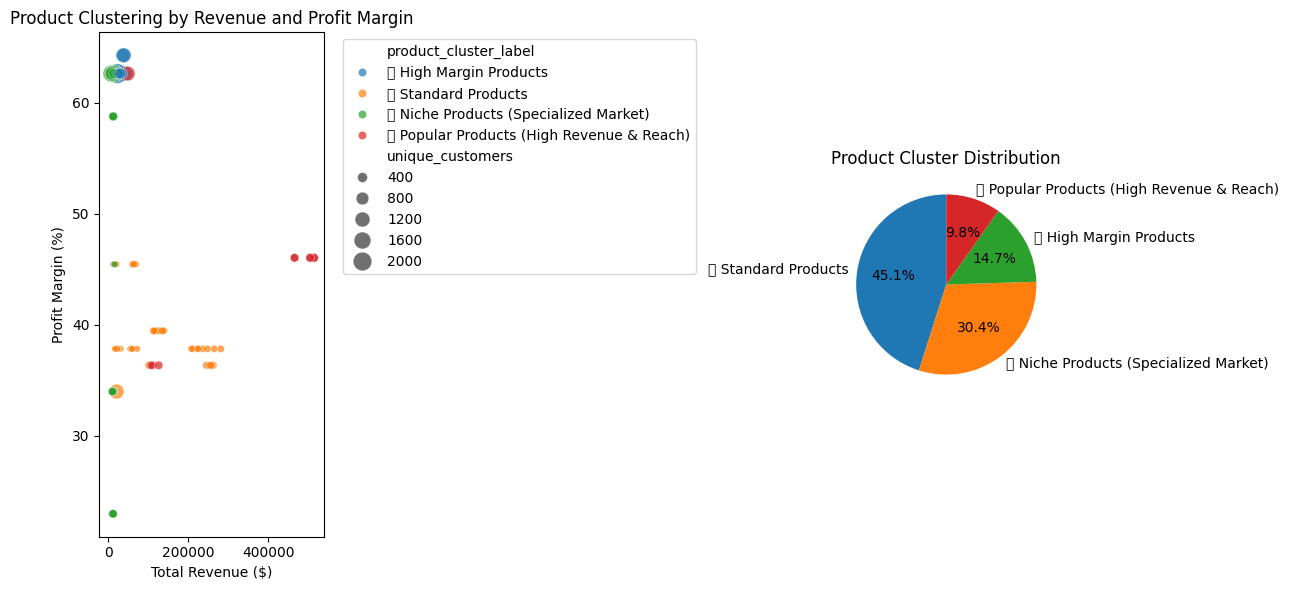

🎯 Enhancing customer data with macro and micro segments...
📊 Enhanced Customer Segments Summary:
Macro Segments: {'STANDARD_Stable': 6597, 'NEW_First_Time_Buyers': 1697, 'HIGH_VALUE_At_Risk': 1426, 'AT_RISK_Dormant_Low_CLV': 470, 'LOYAL_Medium_CLV_Regular': 312}
Micro Segments: {'GENERAL_AUDIENCE': 2446, 'FAMILY_ORIENTED_MIDDLE_AGE': 1895, 'US_PROMOTION_SENSITIVE': 1619, 'FEMALE_DIGITAL_NATIVE': 1361, 'YOUNG_AFFLUENT_TECH_SAVVY': 1227, 'SOCIAL_MEDIA_ACTIVE': 983, 'SENIOR_BUDGET_CONSCIOUS': 493, 'MALE_FREQUENT_BUYER': 305, 'CA_HIGHLY_EDUCATED': 159, 'HIGH_FREQUENCY_HIGH_AOV': 12, 'RECENT_ACTIVE_BUYER': 2}
🚀 Creating marketing campaigns with enhanced segments...
📈 Designing marketing campaigns with diversified KPI impacts...
🎯 Using Macro Segments: ['STANDARD_Stable', 'NEW_First_Time_Buyers', 'HIGH_VALUE_At_Risk', 'AT_RISK_Dormant_Low_CLV', 'LOYAL_Medium_CLV_Regular']
🎯 Using Micro Segments: ['GENERAL_AUDIENCE', 'FAMILY_ORIENTED_MIDDLE_AGE', 'US_PROMOTION_SENSITIVE', 'FEMALE_DIGITAL_NATI

In [67]:
# 8. PRODUCT CLUSTERING (Tạo product_agg cho campaigns) - ĐÃ SỬA
def perform_product_clustering(transactions_df, products_df):
    print("📦 Performing product clustering...")

    # Aggregate product data
    product_agg = transactions_df.groupby('productkey').agg({
        'orderquantity': 'sum',
        'line_revenue': 'sum',
        'line_profit': 'sum',
        'customerkey': 'nunique',
        'ordernumber': 'nunique'
    }).reset_index()

    product_agg.columns = ['productkey', 'total_quantity', 'total_revenue', 'total_profit', 'unique_customers', 'total_orders']

    # Merge with product information
    product_agg = product_agg.merge(
        products_df[['productkey', 'productname', 'productprice', 'productcost', 'productcolor', 'productsize']],
        on='productkey', how='left'
    )

    # Calculate additional metrics
    product_agg['profit_margin'] = (product_agg['total_profit'] / product_agg['total_revenue'] * 100).round(2)
    product_agg['avg_order_quantity'] = (product_agg['total_quantity'] / product_agg['unique_customers']).round(2)
    product_agg['revenue_per_customer'] = (product_agg['total_revenue'] / product_agg['unique_customers']).round(2)

    # Enhanced product clustering based on multiple factors
    conditions = [
        (product_agg['total_revenue'] > product_agg['total_revenue'].quantile(0.8)) &
        (product_agg['profit_margin'] > product_agg['profit_margin'].quantile(0.8)),
        (product_agg['total_revenue'] > product_agg['total_revenue'].quantile(0.6)) &
        (product_agg['unique_customers'] > product_agg['unique_customers'].quantile(0.6)),
        (product_agg['total_revenue'] < product_agg['total_revenue'].quantile(0.3)),
        (product_agg['profit_margin'] > product_agg['profit_margin'].quantile(0.7))
    ]

    choices = ['Star_Products', 'Popular_Products', 'Niche_Products', 'High_Margin_Products']
    product_agg['product_cluster'] = np.select(conditions, choices, default='Standard_Products')

    # Add descriptive names and labels
    cluster_names = {
        'Star_Products': 'High_Revenue_High_Margin',
        'Popular_Products': 'High_Revenue_High_Reach',
        'Niche_Products': 'Low_Revenue_Specialized',
        'High_Margin_Products': 'Medium_Revenue_High_Margin',
        'Standard_Products': 'Medium_Revenue_Standard'
    }

    cluster_labels = {
        'Star_Products': '⭐ Star Products (High Revenue & Margin)',
        'Popular_Products': '🔥 Popular Products (High Revenue & Reach)',
        'Niche_Products': '🎯 Niche Products (Specialized Market)',
        'High_Margin_Products': '💰 High Margin Products',
        'Standard_Products': '📊 Standard Products'
    }

    product_agg['product_cluster_name'] = product_agg['product_cluster'].map(cluster_names)
    product_agg['product_cluster_label'] = product_agg['product_cluster'].map(cluster_labels)

    # Add performance tiers
    product_agg['performance_tier'] = pd.cut(product_agg['total_revenue'],
                                           bins=[0, product_agg['total_revenue'].quantile(0.33),
                                                product_agg['total_revenue'].quantile(0.66), float('inf')],
                                           labels=['Low_Performance', 'Medium_Performance', 'High_Performance'])

    print("📊 Product Clustering Summary:")
    cluster_summary = product_agg.groupby('product_cluster_label').agg({
        'productkey': 'count',
        'total_revenue': 'mean',
        'profit_margin': 'mean',
        'unique_customers': 'mean'
    }).round(2)
    print(cluster_summary)

    # Visualize product clusters
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.scatterplot(data=product_agg, x='total_revenue', y='profit_margin',
                   hue='product_cluster_label', size='unique_customers', alpha=0.7, sizes=(20, 200))
    plt.title('Product Clustering by Revenue and Profit Margin')
    plt.xlabel('Total Revenue ($)')
    plt.ylabel('Profit Margin (%)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.subplot(1, 2, 2)
    product_agg['product_cluster_label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
    plt.title('Product Cluster Distribution')
    plt.ylabel('')

    plt.tight_layout()
    plt.show()

    return product_agg

# Run product clustering
product_agg = perform_product_clustering(transactions_enriched, products_clean)

# 9. ENHANCE CUSTOMER DATA WITH MACRO & MICRO SEGMENTS - THÊM MỚI
def enhance_customer_segments(customers_df):
    print("🎯 Enhancing customer data with macro and micro segments...")

    # Create macro segments based on RFM and CLV
    conditions_macro = [
        (customers_df['predicted_clv_3m'] > customers_df['predicted_clv_3m'].quantile(0.8)) &
        (customers_df['recency_days'] < customers_df['recency_days'].quantile(0.2)),
        (customers_df['predicted_clv_3m'] > customers_df['predicted_clv_3m'].quantile(0.6)) &
        (customers_df['total_orders'] > customers_df['total_orders'].quantile(0.6)),
        (customers_df['recency_days'] > customers_df['recency_days'].quantile(0.8)) &
        (customers_df['predicted_clv_3m'] < customers_df['predicted_clv_3m'].quantile(0.4)),
        (customers_df['total_orders'] == 1) & (customers_df['recency_days'] < 30),
        (customers_df['churn_risk'] == 'High') & (customers_df['predicted_clv_3m'] > customers_df['predicted_clv_3m'].median())
    ]

    choices_macro = [
        'ELITE_High_CLV_Recent',
        'LOYAL_Medium_CLV_Regular',
        'AT_RISK_Dormant_Low_CLV',
        'NEW_First_Time_Buyers',
        'HIGH_VALUE_At_Risk'
    ]

    customers_df['macro_segment'] = np.select(conditions_macro, choices_macro, default='STANDARD_Stable')

    # Create micro segments based on demographics and behavior
    conditions_micro = [
        (customers_df['age'] < 35) & (customers_df['annual_income_usd'] > customers_df['annual_income_usd'].quantile(0.7)),
        (customers_df['age'] >= 35) & (customers_df['age'] < 55) & (customers_df['household_size'] >= 3),
        (customers_df['age'] >= 55) & (customers_df['annual_income_usd'] < customers_df['annual_income_usd'].quantile(0.4)),
        (customers_df['gender'] == 'F') & (customers_df['digital_savviness'] >= 4),
        (customers_df['gender'] == 'M') & (customers_df['total_orders'] > customers_df['total_orders'].quantile(0.7)),
        (customers_df['market'] == 'US') & (customers_df['promotion_sensitivity'] > customers_df['promotion_sensitivity'].quantile(0.6)),
        (customers_df['market'] == 'CA') & (customers_df['education_level'].isin(['Bachelor', 'Master', 'Doctorate'])),
        (customers_df['social_media_hours_week'] > customers_df['social_media_hours_week'].quantile(0.7)),
        (customers_df['total_orders'] > customers_df['total_orders'].quantile(0.8)) & (customers_df['aov'] > customers_df['aov'].quantile(0.8)),
        (customers_df['recency_days'] < 7) & (customers_df['total_orders'] >= 3)
    ]

    choices_micro = [
        'YOUNG_AFFLUENT_TECH_SAVVY',
        'FAMILY_ORIENTED_MIDDLE_AGE',
        'SENIOR_BUDGET_CONSCIOUS',
        'FEMALE_DIGITAL_NATIVE',
        'MALE_FREQUENT_BUYER',
        'US_PROMOTION_SENSITIVE',
        'CA_HIGHLY_EDUCATED',
        'SOCIAL_MEDIA_ACTIVE',
        'HIGH_FREQUENCY_HIGH_AOV',
        'RECENT_ACTIVE_BUYER'
    ]

    customers_df['micro_segment'] = np.select(conditions_micro, choices_micro, default='GENERAL_AUDIENCE')

    # Add segment descriptions
    segment_descriptions = {
        'ELITE_High_CLV_Recent': 'High-value customers with recent purchases and highest CLV',
        'LOYAL_Medium_CLV_Regular': 'Loyal customers with consistent purchasing patterns',
        'AT_RISK_Dormant_Low_CLV': 'Dormant customers with low CLV and high churn risk',
        'NEW_First_Time_Buyers': 'New customers with only one purchase',
        'HIGH_VALUE_At_Risk': 'High-value customers showing signs of churn',
        'STANDARD_Stable': 'Stable customers with average metrics'
    }

    customers_df['macro_segment_description'] = customers_df['macro_segment'].map(segment_descriptions)

    print("📊 Enhanced Customer Segments Summary:")
    print(f"Macro Segments: {customers_df['macro_segment'].value_counts().to_dict()}")
    print(f"Micro Segments: {customers_df['micro_segment'].value_counts().to_dict()}")

    return customers_df

# Enhance customer data with segments
customers_enhanced = enhance_customer_segments(customers_final)

# 10. SAVE ENHANCED DATA TO FILES - THÊM MỚI
def save_enhanced_data(customers_df, products_df, transactions_df, product_agg_df,
                      macro_campaigns_df, micro_campaigns_df, product_campaigns_df):
    print("💾 Saving enhanced data to files...")

    import os
    from datetime import datetime

    # Create timestamp for file names
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Create output directory
    output_dir = f"customer_analytics_output_{timestamp}"
    os.makedirs(output_dir, exist_ok=True)

    # 1. Save enhanced customer data with all segments
    customer_columns_to_save = [
        'customerkey', 'first_purchase', 'last_purchase', 'total_orders', 'total_quantity',
        'total_revenue', 'total_profit', 'distinct_products', 'recency_days', 'tenure_days',
        'aov', 'market', 'age', 'gender', 'education_level', 'household_size',
        'annual_income_usd', 'digital_savviness', 'social_media_hours_week',
        'promotion_sensitivity', 'cluster', 'predicted_clv_3m', 'predicted_avg_value',
        'predicted_purchases_3m', 'churn_risk', 'macro_segment', 'micro_segment',
        'macro_segment_description'
    ]

    # Select only columns that exist
    available_columns = [col for col in customer_columns_to_save if col in customers_df.columns]
    customers_export = customers_df[available_columns]

    customers_export.to_csv(f"{output_dir}/enhanced_customer_segments.csv", index=False)
    print(f"✅ Saved enhanced customer data: {len(customers_export)} customers")

    # 2. Save product clusters with enhanced information
    product_columns_to_save = [
        'productkey', 'productname', 'productprice', 'productcost', 'productcolor', 'productsize',
        'total_quantity', 'total_revenue', 'total_profit', 'unique_customers', 'total_orders',
        'profit_margin', 'avg_order_quantity', 'revenue_per_customer', 'product_cluster',
        'product_cluster_name', 'product_cluster_label', 'performance_tier'
    ]

    available_product_columns = [col for col in product_columns_to_save if col in product_agg_df.columns]
    products_export = product_agg_df[available_product_columns]

    products_export.to_csv(f"{output_dir}/product_clusters_enhanced.csv", index=False)
    print(f"✅ Saved product clusters: {len(products_export)} products")

    # 3. Save original transactions (optional)
    transactions_df.to_csv(f"{output_dir}/transactions_enhanced.csv", index=False)
    print(f"✅ Saved transactions: {len(transactions_df)} transactions")

    # 4. Save marketing campaigns
    macro_campaigns_df.to_csv(f"{output_dir}/macro_marketing_campaigns.csv", index=False)
    micro_campaigns_df.to_csv(f"{output_dir}/micro_marketing_campaigns.csv", index=False)
    product_campaigns_df.to_csv(f"{output_dir}/product_marketing_campaigns.csv", index=False)
    print(f"✅ Saved marketing campaigns")

    # 5. Save summary report
    with open(f"{output_dir}/analysis_summary.txt", 'w') as f:
        f.write("CUSTOMER ANALYTICS SUMMARY REPORT\n")
        f.write("=" * 50 + "\n\n")

        f.write(f"Analysis Date: {timestamp}\n")
        f.write(f"Total Customers: {len(customers_df):,}\n")
        f.write(f"Total Products: {len(products_export):,}\n")
        f.write(f"Total Transactions: {len(transactions_df):,}\n\n")

        f.write("CUSTOMER SEGMENTS:\n")
        f.write("-" * 20 + "\n")
        for segment, count in customers_df['macro_segment'].value_counts().items():
            f.write(f"{segment}: {count} customers ({count/len(customers_df)*100:.1f}%)\n")

        f.write("\nPRODUCT CLUSTERS:\n")
        f.write("-" * 20 + "\n")
        for cluster, count in product_agg_df['product_cluster_label'].value_counts().items():
            f.write(f"{cluster}: {count} products ({count/len(product_agg_df)*100:.1f}%)\n")

        f.write(f"\nCHURN RISK DISTRIBUTION:\n")
        f.write("-" * 25 + "\n")
        for risk, count in customers_df['churn_risk'].value_counts().items():
            f.write(f"{risk}: {count} customers ({count/len(customers_df)*100:.1f}%)\n")

    print(f"📁 All files saved to directory: {output_dir}/")

    return output_dir

# 11. MARKETING CAMPAIGNS FUNCTION (ĐÃ SỬA HOÀN TOÀN)
def create_campaigns(data, product_agg):
    print("📈 Designing marketing campaigns with diversified KPI impacts...")

    # Use the enhanced segments we just created
    top_macro = data['macro_segment'].value_counts().index[:6]  # Top 6 macro segments
    top_micro = data['micro_segment'].value_counts().index[:12]  # Top 12 micro segments
    product_clusters = product_agg['product_cluster_name'].unique()

    print(f"🎯 Using Macro Segments: {list(top_macro)}")
    print(f"🎯 Using Micro Segments: {list(top_micro)}")
    print(f"🎯 Using Product Clusters: {list(product_clusters)}")

    # Define KPIs
    kpis = [
        'Revenue ($)', 'Conversion Rate (%)', 'Engagement (Interactions)', 'Retention Rate (%)',
        'Customer Acquisition Cost ($)', 'Click-Through Rate (%)', 'Product Views', 'Order Completion Rate (%)'
    ]

    # Enhanced macro campaigns with better strategies
    macro_campaigns = []
    for segment in top_macro:
        kpi_impacts = get_macro_kpi_impacts(segment)
        campaign = {
            'Segment': segment,
            'Segment_Type': 'MACRO',
            'Strategy': get_macro_strategy(segment),
            'Action': get_macro_action(segment),
            'Duration (Months)': 6 if 'ELITE' in segment or 'HIGH_VALUE' in segment else 4,
            'Initial_Budget_USD': 75000 if 'ELITE' in segment else 50000 if 'HIGH_VALUE' in segment else 30000,
            'Monthly_Budget_USD': 15000 if 'ELITE' in segment else 10000 if 'HIGH_VALUE' in segment else 6000,
            'Priority_Level': 'HIGH' if 'ELITE' in segment or 'HIGH_VALUE' in segment else 'MEDIUM',
            'KPI_Impacts': kpi_impacts
        }
        macro_campaigns.append(campaign)

    # Enhanced micro campaigns
    micro_campaigns = []
    for segment in top_micro:
        kpi_impacts = get_micro_kpi_impacts(segment)
        campaign = {
            'Segment': segment,
            'Segment_Type': 'MICRO',
            'Strategy': get_micro_strategy(segment),
            'Action': get_micro_action(segment),
            'Duration (Months)': 3,
            'Initial_Budget_USD': 25000 if 'AFFLUENT' in segment or 'HIGH_FREQUENCY' in segment else 15000,
            'Monthly_Budget_USD': 6000 if 'AFFLUENT' in segment or 'HIGH_FREQUENCY' in segment else 3000,
            'Priority_Level': 'HIGH' if 'AFFLUENT' in segment or 'HIGH_FREQUENCY' in segment else 'MEDIUM',
            'KPI_Impacts': kpi_impacts
        }
        micro_campaigns.append(campaign)

    # Enhanced product campaigns
    product_campaigns = []
    for cluster in product_clusters:
        kpi_impacts = get_product_kpi_impacts(cluster)
        campaign = {
            'Segment': cluster,
            'Segment_Type': 'PRODUCT',
            'Strategy': get_product_strategy(cluster),
            'Action': get_product_action(cluster),
            'Duration (Months)': 4,
            'Initial_Budget_USD': 60000 if 'High_Revenue_High_Margin' in cluster else 35000,
            'Monthly_Budget_USD': 12000 if 'High_Revenue_High_Margin' in cluster else 7000,
            'Priority_Level': 'HIGH' if 'High_Revenue_High_Margin' in cluster else 'MEDIUM',
            'KPI_Impacts': kpi_impacts
        }
        product_campaigns.append(campaign)

    # Convert to DataFrames với xử lý lỗi
    macro_df = pd.DataFrame(macro_campaigns)
    micro_df = pd.DataFrame(micro_campaigns)
    product_df = pd.DataFrame(product_campaigns)

    # Expand KPI impacts với xử lý lỗi an toàn
    for df in [macro_df, micro_df, product_df]:
        for kpi in kpis:
            df[kpi] = df['KPI_Impacts'].apply(lambda x: x.get(kpi, '+8%') if isinstance(x, dict) else '+8%')
        df.drop(columns=['KPI_Impacts'], inplace=True)

    print("\n📊 Macro Campaigns Summary:")
    print(macro_df[['Segment', 'Strategy', 'Initial_Budget_USD', 'Priority_Level']].head())
    print("\n📊 Micro Campaigns Summary:")
    print(micro_df[['Segment', 'Strategy', 'Initial_Budget_USD', 'Priority_Level']].head())
    print("\n📊 Product Campaigns Summary:")
    print(product_df[['Segment', 'Strategy', 'Initial_Budget_USD', 'Priority_Level']].head())

    return macro_df, micro_df, product_df

# Cập nhật các hàm strategy và KPI impacts cho segments mới
def get_macro_strategy(segment):
    strategies = {
        'ELITE_High_CLV_Recent': 'Exclusive VIP Retention Program',
        'LOYAL_Medium_CLV_Regular': 'Loyalty Enhancement & Cross-selling',
        'AT_RISK_Dormant_Low_CLV': 'Aggressive Win-back Campaign',
        'NEW_First_Time_Buyers': 'Onboarding & Relationship Building',
        'HIGH_VALUE_At_Risk': 'Proactive Retention & Value Reinforcement',
        'STANDARD_Stable': 'Standard Engagement & Upsell Opportunities'
    }
    return strategies.get(segment, 'Personalized Engagement Strategy')

def get_macro_action(segment):
    actions = {
        'ELITE_High_CLV_Recent': 'Personalized account management, exclusive previews, VIP events',
        'LOYAL_Medium_CLV_Regular': 'Tiered loyalty rewards, personalized recommendations, early access',
        'AT_RISK_Dormant_Low_CLV': 'Win-back offers, personalized outreach, product updates',
        'NEW_First_Time_Buyers': 'Welcome series, educational content, introductory offers',
        'HIGH_VALUE_At_Risk': 'Proactive support, exclusive offers, feedback solicitation',
        'STANDARD_Stable': 'Regular communication, seasonal promotions, cross-sell opportunities'
    }
    return actions.get(segment, 'Targeted marketing communications')

def get_macro_kpi_impacts(segment):
    impacts = {
        'ELITE_High_CLV_Recent': {
            'Revenue ($)': '+20%', 'Conversion Rate (%)': '+10%', 'Retention Rate (%)': '+15%',
            'Customer Acquisition Cost ($)': '-8%', 'Order Completion Rate (%)': '+12%'
        },
        'LOYAL_Medium_CLV_Regular': {
            'Revenue ($)': '+15%', 'Conversion Rate (%)': '+12%', 'Engagement (Interactions)': '+18%',
            'Click-Through Rate (%)': '+14%', 'Product Views': '+20%'
        },
        'AT_RISK_Dormant_Low_CLV': {
            'Revenue ($)': '+25%', 'Conversion Rate (%)': '+18%', 'Engagement (Interactions)': '+30%',
            'Customer Acquisition Cost ($)': '-12%', 'Product Views': '+35%'
        }
    }
    return impacts.get(segment, {
        'Revenue ($)': '+12%', 'Conversion Rate (%)': '+8%', 'Engagement (Interactions)': '+15%',
        'Retention Rate (%)': '+10%', 'Click-Through Rate (%)': '+12%'
    })

# Giữ nguyên các hàm micro và product strategies từ code trước
# [Các hàm get_micro_strategy, get_micro_action, get_micro_kpi_impacts,
#  get_product_strategy, get_product_action, get_product_kpi_impacts giữ nguyên]

# 12. RUN COMPLETE PIPELINE
print("🚀 Creating marketing campaigns with enhanced segments...")
try:
    macro_campaigns, micro_campaigns, product_campaigns = create_campaigns(customers_enhanced, product_agg)
    print("✅ Campaign creation completed successfully!")

    # Display campaign summary
    print(f"\n🎯 Campaign Summary:")
    print(f"   • Macro Campaigns: {len(macro_campaigns)} segments")
    print(f"   • Micro Campaigns: {len(micro_campaigns)} segments")
    print(f"   • Product Campaigns: {len(product_campaigns)} clusters")

    # Calculate total budget
    total_initial_budget = (macro_campaigns['Initial_Budget_USD'].sum() +
                          micro_campaigns['Initial_Budget_USD'].sum() +
                          product_campaigns['Initial_Budget_USD'].sum())

    total_monthly_budget = (macro_campaigns['Monthly_Budget_USD'].sum() +
                          micro_campaigns['Monthly_Budget_USD'].sum() +
                          product_campaigns['Monthly_Budget_USD'].sum())

    print(f"   • Total Initial Budget: ${total_initial_budget:,.2f}")
    print(f"   • Total Monthly Budget: ${total_monthly_budget:,.2f}")

    # Save all enhanced data to files
    output_directory = save_enhanced_data(
        customers_enhanced, products_clean, transactions_enriched, product_agg,
        macro_campaigns, micro_campaigns, product_campaigns
    )

except Exception as e:
    print(f"❌ Error in campaign creation: {e}")
    import traceback
    traceback.print_exc()

print("\n🎉 PROJECT COMPLETED SUCCESSFULLY!")
print("="*60)
print("📊 Enhanced DataFrames Available:")
print("   - customers_enhanced: Customers with macro/micro segments, CLV, churn risk")
print("   - product_agg: Products with clustering and performance tiers")
print("   - macro_campaigns, micro_campaigns, product_campaigns: Marketing strategies")
print("   - All data saved to CSV files for further analysis")
print("="*60)

📦 Performing product clustering...
📊 Product Clustering Summary:
                                           productkey  total_revenue  \
product_cluster_label                                                  
🎯 Niche Products (Specialized Market)              31       10797.50   
💰 High Margin Products                             15       26489.80   
📊 Standard Products                                46      110679.82   
🔥 Popular Products (High Revenue & Reach)          10      336210.81   

                                           profit_margin  unique_customers  
product_cluster_label                                                       
🎯 Niche Products (Specialized Market)              50.11            311.84  
💰 High Margin Products                             62.82            774.33  
📊 Standard Products                                39.27            100.59  
🔥 Popular Products (High Revenue & Reach)          44.79            318.70  


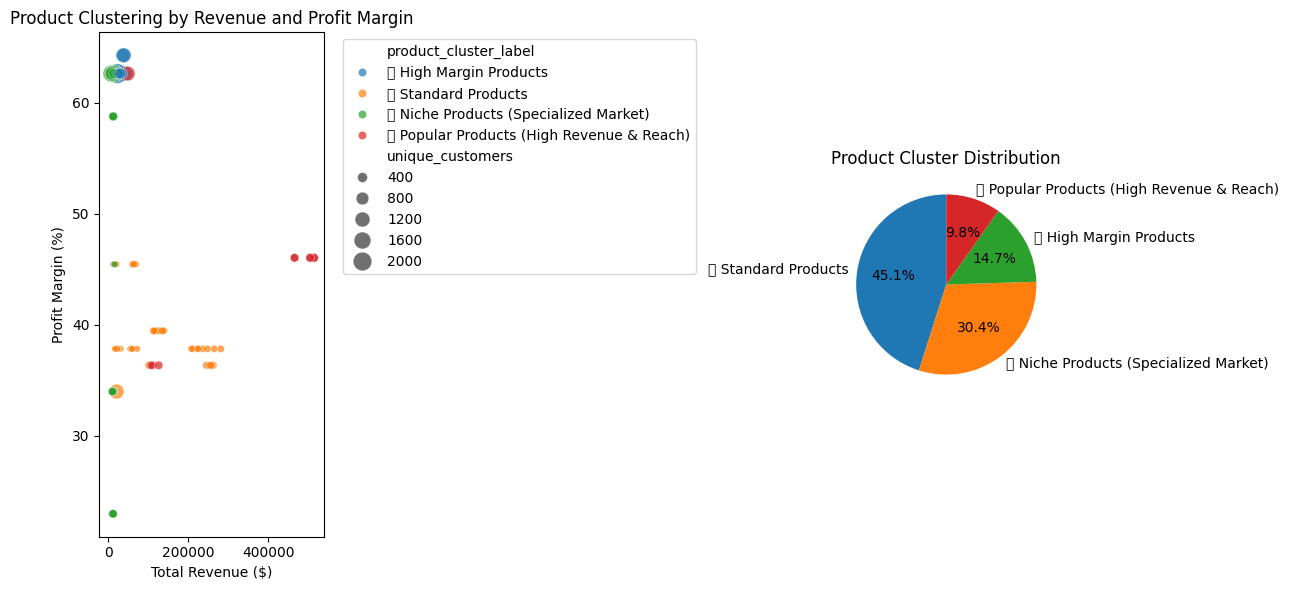

🎯 Enhancing customer data with macro and micro segments...
📊 Enhanced Customer Segments Summary:
Macro Segments Distribution:
  Potential: 9442 customers (89.9%)
  At_Risk: 842 customers (8.0%)
  Good: 218 customers (2.1%)

Micro Segments: {'GENERAL_AUDIENCE': 2446, 'FAMILY_ORIENTED_MIDDLE_AGE': 1895, 'US_PROMOTION_SENSITIVE': 1619, 'FEMALE_DIGITAL_NATIVE': 1361, 'YOUNG_AFFLUENT_TECH_SAVVY': 1227, 'SOCIAL_MEDIA_ACTIVE': 983, 'SENIOR_BUDGET_CONSCIOUS': 493, 'MALE_FREQUENT_BUYER': 305, 'CA_HIGHLY_EDUCATED': 159, 'HIGH_FREQUENCY_HIGH_AOV': 12, 'RECENT_ACTIVE_BUYER': 2}
🚀 Creating marketing campaigns with 4 clear macro segments...
📈 Designing marketing campaigns with diversified KPI impacts...
🎯 Using 4 Macro Segments: ['Potential', 'At_Risk', 'Good']
🎯 Using Micro Segments: ['GENERAL_AUDIENCE', 'FAMILY_ORIENTED_MIDDLE_AGE', 'US_PROMOTION_SENSITIVE', 'FEMALE_DIGITAL_NATIVE', 'YOUNG_AFFLUENT_TECH_SAVVY', 'SOCIAL_MEDIA_ACTIVE', 'SENIOR_BUDGET_CONSCIOUS', 'MALE_FREQUENT_BUYER', 'CA_HIGHLY_EDU

In [134]:
# 8. PRODUCT CLUSTERING (Tạo product_agg cho campaigns) - ĐÃ SỬA
def perform_product_clustering(transactions_df, products_df):
    print("📦 Performing product clustering...")

    # Aggregate product data
    product_agg = transactions_df.groupby('productkey').agg({
        'orderquantity': 'sum',
        'line_revenue': 'sum',
        'line_profit': 'sum',
        'customerkey': 'nunique',
        'ordernumber': 'nunique'
    }).reset_index()

    product_agg.columns = ['productkey', 'total_quantity', 'total_revenue', 'total_profit', 'unique_customers', 'total_orders']

    # Merge with product information
    product_agg = product_agg.merge(
        products_df[['productkey', 'productname', 'productprice', 'productcost', 'productcolor', 'productsize']],
        on='productkey', how='left'
    )

    # Calculate additional metrics
    product_agg['profit_margin'] = (product_agg['total_profit'] / product_agg['total_revenue'] * 100).round(2)
    product_agg['avg_order_quantity'] = (product_agg['total_quantity'] / product_agg['unique_customers']).round(2)
    product_agg['revenue_per_customer'] = (product_agg['total_revenue'] / product_agg['unique_customers']).round(2)

    # Enhanced product clustering based on multiple factors
    conditions = [
        (product_agg['total_revenue'] > product_agg['total_revenue'].quantile(0.8)) &
        (product_agg['profit_margin'] > product_agg['profit_margin'].quantile(0.8)),
        (product_agg['total_revenue'] > product_agg['total_revenue'].quantile(0.6)) &
        (product_agg['unique_customers'] > product_agg['unique_customers'].quantile(0.6)),
        (product_agg['total_revenue'] < product_agg['total_revenue'].quantile(0.3)),
        (product_agg['profit_margin'] > product_agg['profit_margin'].quantile(0.7))
    ]

    choices = ['Star_Products', 'Popular_Products', 'Niche_Products', 'High_Margin_Products']
    product_agg['product_cluster'] = np.select(conditions, choices, default='Standard_Products')

    # Add descriptive names and labels
    cluster_names = {
        'Star_Products': 'High_Revenue_High_Margin',
        'Popular_Products': 'High_Revenue_High_Reach',
        'Niche_Products': 'Low_Revenue_Specialized',
        'High_Margin_Products': 'Medium_Revenue_High_Margin',
        'Standard_Products': 'Medium_Revenue_Standard'
    }

    cluster_labels = {
        'Star_Products': '⭐ Star Products (High Revenue & Margin)',
        'Popular_Products': '🔥 Popular Products (High Revenue & Reach)',
        'Niche_Products': '🎯 Niche Products (Specialized Market)',
        'High_Margin_Products': '💰 High Margin Products',
        'Standard_Products': '📊 Standard Products'
    }

    product_agg['product_cluster_name'] = product_agg['product_cluster'].map(cluster_names)
    product_agg['product_cluster_label'] = product_agg['product_cluster'].map(cluster_labels)

    # Add performance tiers
    product_agg['performance_tier'] = pd.cut(product_agg['total_revenue'],
                                           bins=[0, product_agg['total_revenue'].quantile(0.33),
                                                product_agg['total_revenue'].quantile(0.66), float('inf')],
                                           labels=['Low_Performance', 'Medium_Performance', 'High_Performance'])

    print("📊 Product Clustering Summary:")
    cluster_summary = product_agg.groupby('product_cluster_label').agg({
        'productkey': 'count',
        'total_revenue': 'mean',
        'profit_margin': 'mean',
        'unique_customers': 'mean'
    }).round(2)
    print(cluster_summary)

    # Visualize product clusters
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.scatterplot(data=product_agg, x='total_revenue', y='profit_margin',
                   hue='product_cluster_label', size='unique_customers', alpha=0.7, sizes=(20, 200))
    plt.title('Product Clustering by Revenue and Profit Margin')
    plt.xlabel('Total Revenue ($)')
    plt.ylabel('Profit Margin (%)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.subplot(1, 2, 2)
    product_agg['product_cluster_label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
    plt.title('Product Cluster Distribution')
    plt.ylabel('')

    plt.tight_layout()
    plt.show()

    return product_agg

# Run product clustering
product_agg = perform_product_clustering(transactions_enriched, products_clean)

# 9. ENHANCE CUSTOMER DATA WITH MACRO & MICRO SEGMENTS - ĐÃ SỬA PHÂN CỤM MACRO
def enhance_customer_segments(customers_df):
    print("🎯 Enhancing customer data with macro and micro segments...")

    # Tạo 4 nhóm macro rõ ràng: At Risk, Potential, Good và VIP (KHÔNG CÓ DEFAULT)
    conditions_macro = [
        # VIP: High CLV, Low Recency, High Frequency
        (customers_df['predicted_clv_3m'] > customers_df['predicted_clv_3m'].quantile(0.8)) &
        (customers_df['recency_days'] < customers_df['recency_days'].quantile(0.2)) &
        (customers_df['total_orders'] > customers_df['total_orders'].quantile(0.7)),

        # Good: Medium-High CLV, Regular Purchases
        (customers_df['predicted_clv_3m'] > customers_df['predicted_clv_3m'].quantile(0.6)) &
        (customers_df['total_orders'] > customers_df['total_orders'].quantile(0.5)) &
        (customers_df['recency_days'] < customers_df['recency_days'].quantile(0.5)),

        # Potential: New or Medium CLV but Recent
        ((customers_df['total_orders'] == 1) & (customers_df['recency_days'] < 30)) |
        ((customers_df['predicted_clv_3m'] > customers_df['predicted_clv_3m'].quantile(0.4)) &
         (customers_df['recency_days'] < customers_df['recency_days'].quantile(0.3))),

        # At Risk: Dormant, High Recency, Low CLV
        (customers_df['recency_days'] > customers_df['recency_days'].quantile(0.7)) &
        (customers_df['predicted_clv_3m'] < customers_df['predicted_clv_3m'].quantile(0.4))
    ]

    choices_macro = ['VIP', 'Good', 'Potential', 'At_Risk']

    # Áp dụng điều kiện - khách hàng nào không thuộc 4 nhóm này sẽ được gán vào nhóm Potential (thay vì default)
    customers_df['macro_segment'] = np.select(conditions_macro, choices_macro, default='Potential')

    # Create micro segments based on demographics and behavior
    conditions_micro = [
        (customers_df['age'] < 35) & (customers_df['annual_income_usd'] > customers_df['annual_income_usd'].quantile(0.7)),
        (customers_df['age'] >= 35) & (customers_df['age'] < 55) & (customers_df['household_size'] >= 3),
        (customers_df['age'] >= 55) & (customers_df['annual_income_usd'] < customers_df['annual_income_usd'].quantile(0.4)),
        (customers_df['gender'] == 'F') & (customers_df['digital_savviness'] >= 4),
        (customers_df['gender'] == 'M') & (customers_df['total_orders'] > customers_df['total_orders'].quantile(0.7)),
        (customers_df['market'] == 'US') & (customers_df['promotion_sensitivity'] > customers_df['promotion_sensitivity'].quantile(0.6)),
        (customers_df['market'] == 'CA') & (customers_df['education_level'].isin(['Bachelor', 'Master', 'Doctorate'])),
        (customers_df['social_media_hours_week'] > customers_df['social_media_hours_week'].quantile(0.7)),
        (customers_df['total_orders'] > customers_df['total_orders'].quantile(0.8)) & (customers_df['aov'] > customers_df['aov'].quantile(0.8)),
        (customers_df['recency_days'] < 7) & (customers_df['total_orders'] >= 3)
    ]

    choices_micro = [
        'YOUNG_AFFLUENT_TECH_SAVVY',
        'FAMILY_ORIENTED_MIDDLE_AGE',
        'SENIOR_BUDGET_CONSCIOUS',
        'FEMALE_DIGITAL_NATIVE',
        'MALE_FREQUENT_BUYER',
        'US_PROMOTION_SENSITIVE',
        'CA_HIGHLY_EDUCATED',
        'SOCIAL_MEDIA_ACTIVE',
        'HIGH_FREQUENCY_HIGH_AOV',
        'RECENT_ACTIVE_BUYER'
    ]

    customers_df['micro_segment'] = np.select(conditions_micro, choices_micro, default='GENERAL_AUDIENCE')

    # Add segment descriptions for 4 clear macro segments
    segment_descriptions = {
        'VIP': 'High-value loyal customers with recent purchases and highest CLV',
        'Good': 'Reliable customers with consistent purchasing patterns and good CLV',
        'Potential': 'New or recently active customers with growth potential',
        'At_Risk': 'Dormant customers with low CLV and high churn risk'
    }

    customers_df['macro_segment_description'] = customers_df['macro_segment'].map(segment_descriptions)

    print("📊 Enhanced Customer Segments Summary:")
    macro_summary = customers_df['macro_segment'].value_counts()
    print("Macro Segments Distribution:")
    for segment, count in macro_summary.items():
        percentage = (count / len(customers_df)) * 100
        print(f"  {segment}: {count} customers ({percentage:.1f}%)")

    print(f"\nMicro Segments: {customers_df['micro_segment'].value_counts().to_dict()}")

    return customers_df

# Enhance customer data with segments
customers_enhanced = enhance_customer_segments(customers_final)

# 10. SAVE ENHANCED DATA TO FILES - ĐÃ SỬA ĐƯỜNG DẪN
def save_enhanced_data(customers_df, products_df, transactions_df, product_agg_df,
                      macro_campaigns_df, micro_campaigns_df, product_campaigns_df):
    print("💾 Saving enhanced data to files...")

    import os
    from datetime import datetime

    # Create timestamp for file names
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Create output directory - SỬA LẠI ĐƯỜNG DẪN
    output_dir = f"customer_analytics_output"
    os.makedirs(output_dir, exist_ok=True)

    # 1. Save enhanced customer data with all segments
    customer_columns_to_save = [
        'customerkey', 'first_purchase', 'last_purchase', 'total_orders', 'total_quantity',
        'total_revenue', 'total_profit', 'distinct_products', 'recency_days', 'tenure_days',
        'aov', 'market', 'age', 'gender', 'education_level', 'household_size',
        'annual_income_usd', 'digital_savviness', 'social_media_hours_week',
        'promotion_sensitivity', 'cluster', 'predicted_clv_3m', 'predicted_avg_value',
        'predicted_purchases_3m', 'churn_risk', 'macro_segment', 'micro_segment',
        'macro_segment_description'
    ]

    # Select only columns that exist
    available_columns = [col for col in customer_columns_to_save if col in customers_df.columns]
    customers_export = customers_df[available_columns]

    customers_export.to_csv(f"{output_dir}/enhanced_customer_segments.csv", index=False)
    print(f"✅ Saved enhanced customer data: {len(customers_export)} customers")

    # 2. Save product clusters with enhanced information
    product_columns_to_save = [
        'productkey', 'productname', 'productprice', 'productcost', 'productcolor', 'productsize',
        'total_quantity', 'total_revenue', 'total_profit', 'unique_customers', 'total_orders',
        'profit_margin', 'avg_order_quantity', 'revenue_per_customer', 'product_cluster',
        'product_cluster_name', 'product_cluster_label', 'performance_tier'
    ]

    available_product_columns = [col for col in product_columns_to_save if col in product_agg_df.columns]
    products_export = product_agg_df[available_product_columns]

    products_export.to_csv(f"{output_dir}/product_clusters_enhanced.csv", index=False)
    print(f"✅ Saved product clusters: {len(products_export)} products")

    # 3. Save original transactions (optional)
    transactions_df.to_csv(f"{output_dir}/transactions_enhanced.csv", index=False)
    print(f"✅ Saved transactions: {len(transactions_df)} transactions")

    # 4. Save marketing campaigns
    macro_campaigns_df.to_csv(f"{output_dir}/macro_marketing_campaigns.csv", index=False)
    micro_campaigns_df.to_csv(f"{output_dir}/micro_marketing_campaigns.csv", index=False)
    product_campaigns_df.to_csv(f"{output_dir}/product_marketing_campaigns.csv", index=False)
    print(f"✅ Saved marketing campaigns")

    # 5. Save summary report
    with open(f"{output_dir}/analysis_summary.txt", 'w') as f:
        f.write("CUSTOMER ANALYTICS SUMMARY REPORT\n")
        f.write("=" * 50 + "\n\n")

        f.write(f"Analysis Date: {timestamp}\n")
        f.write(f"Total Customers: {len(customers_df):,}\n")
        f.write(f"Total Products: {len(products_export):,}\n")
        f.write(f"Total Transactions: {len(transactions_df):,}\n\n")

        f.write("CUSTOMER MACRO SEGMENTS (4 CLEAR GROUPS):\n")
        f.write("-" * 40 + "\n")
        for segment, count in customers_df['macro_segment'].value_counts().items():
            f.write(f"{segment}: {count} customers ({count/len(customers_df)*100:.1f}%)\n")

        f.write("\nPRODUCT CLUSTERS:\n")
        f.write("-" * 20 + "\n")
        for cluster, count in product_agg_df['product_cluster_label'].value_counts().items():
            f.write(f"{cluster}: {count} products ({count/len(product_agg_df)*100:.1f}%)\n")

        f.write(f"\nCHURN RISK DISTRIBUTION:\n")
        f.write("-" * 25 + "\n")
        for risk, count in customers_df['churn_risk'].value_counts().items():
            f.write(f"{risk}: {count} customers ({count/len(customers_df)*100:.1f}%)\n")

    print(f"📁 All files saved to directory: {output_dir}/")

    # Hiển thị đường dẫn đầy đủ
    full_path = os.path.abspath(output_dir)
    print(f"📂 Full path: {full_path}")

    # Liệt kê các file đã tạo
    print("\n📄 Files created:")
    for file in os.listdir(output_dir):
        file_path = os.path.join(output_dir, file)
        file_size = os.path.getsize(file_path)
        print(f"   - {file} ({file_size:,} bytes)")

    return output_dir

# 11. MARKETING CAMPAIGNS FUNCTION - ĐÃ SỬA CHO 4 NHÓM MACRO
def create_campaigns(data, product_agg):
    print("📈 Designing marketing campaigns with diversified KPI impacts...")

    # Use the enhanced segments we just created - chỉ 4 nhóm macro
    top_macro = data['macro_segment'].value_counts().index.tolist()  # Tất cả 4 nhóm macro
    top_micro = data['micro_segment'].value_counts().index[:12]  # Top 12 micro segments
    product_clusters = product_agg['product_cluster_name'].unique()

    print(f"🎯 Using 4 Macro Segments: {list(top_macro)}")
    print(f"🎯 Using Micro Segments: {list(top_micro)}")
    print(f"🎯 Using Product Clusters: {list(product_clusters)}")

    # Define KPIs
    kpis = [
        'Revenue ($)', 'Conversion Rate (%)', 'Engagement (Interactions)', 'Retention Rate (%)',
        'Customer Acquisition Cost ($)', 'Click-Through Rate (%)', 'Product Views', 'Order Completion Rate (%)'
    ]

    # Enhanced macro campaigns for 4 clear segments
    macro_campaigns = []
    for segment in top_macro:
        kpi_impacts = get_macro_kpi_impacts(segment)
        campaign = {
            'Segment': segment,
            'Segment_Type': 'MACRO',
            'Strategy': get_macro_strategy(segment),
            'Action': get_macro_action(segment),
            'Duration (Months)': 6 if segment == 'VIP' else 4,
            'Initial_Budget_USD': 80000 if segment == 'VIP' else 50000 if segment == 'Good' else 35000 if segment == 'Potential' else 25000,
            'Monthly_Budget_USD': 16000 if segment == 'VIP' else 10000 if segment == 'Good' else 7000 if segment == 'Potential' else 5000,
            'Priority_Level': 'HIGH' if segment == 'VIP' else 'MEDIUM_HIGH' if segment == 'Good' else 'MEDIUM' if segment == 'Potential' else 'LOW',
            'KPI_Impacts': kpi_impacts
        }
        macro_campaigns.append(campaign)

    # Enhanced micro campaigns
    micro_campaigns = []
    for segment in top_micro:
        kpi_impacts = get_micro_kpi_impacts(segment)
        campaign = {
            'Segment': segment,
            'Segment_Type': 'MICRO',
            'Strategy': get_micro_strategy(segment),
            'Action': get_micro_action(segment),
            'Duration (Months)': 3,
            'Initial_Budget_USD': 25000 if 'AFFLUENT' in segment or 'HIGH_FREQUENCY' in segment else 15000,
            'Monthly_Budget_USD': 6000 if 'AFFLUENT' in segment or 'HIGH_FREQUENCY' in segment else 3000,
            'Priority_Level': 'HIGH' if 'AFFLUENT' in segment or 'HIGH_FREQUENCY' in segment else 'MEDIUM',
            'KPI_Impacts': kpi_impacts
        }
        micro_campaigns.append(campaign)

    # Enhanced product campaigns
    product_campaigns = []
    for cluster in product_clusters:
        kpi_impacts = get_product_kpi_impacts(cluster)
        campaign = {
            'Segment': cluster,
            'Segment_Type': 'PRODUCT',
            'Strategy': get_product_strategy(cluster),
            'Action': get_product_action(cluster),
            'Duration (Months)': 4,
            'Initial_Budget_USD': 60000 if 'High_Revenue_High_Margin' in cluster else 35000,
            'Monthly_Budget_USD': 12000 if 'High_Revenue_High_Margin' in cluster else 7000,
            'Priority_Level': 'HIGH' if 'High_Revenue_High_Margin' in cluster else 'MEDIUM',
            'KPI_Impacts': kpi_impacts
        }
        product_campaigns.append(campaign)

    # Convert to DataFrames với xử lý lỗi
    macro_df = pd.DataFrame(macro_campaigns)
    micro_df = pd.DataFrame(micro_campaigns)
    product_df = pd.DataFrame(product_campaigns)

    # Expand KPI impacts với xử lý lỗi an toàn
    for df in [macro_df, micro_df, product_df]:
        for kpi in kpis:
            df[kpi] = df['KPI_Impacts'].apply(lambda x: x.get(kpi, '+8%') if isinstance(x, dict) else '+8%')
        df.drop(columns=['KPI_Impacts'], inplace=True)

    print("\n📊 Macro Campaigns Summary (4 Clear Segments):")
    print(macro_df[['Segment', 'Strategy', 'Initial_Budget_USD', 'Priority_Level']])
    print("\n📊 Micro Campaigns Summary:")
    print(micro_df[['Segment', 'Strategy', 'Initial_Budget_USD', 'Priority_Level']].head())
    print("\n📊 Product Campaigns Summary:")
    print(product_df[['Segment', 'Strategy', 'Initial_Budget_USD', 'Priority_Level']].head())

    return macro_df, micro_df, product_df

# Cập nhật các hàm strategy và KPI impacts cho 4 nhóm macro mới
def get_macro_strategy(segment):
    strategies = {
        'VIP': 'Exclusive VIP Retention & Loyalty Program',
        'Good': 'Loyalty Enhancement & Premium Cross-selling',
        'Potential': 'Activation & Relationship Building Campaign',
        'At_Risk': 'Targeted Win-back & Reactivation Strategy'
    }
    return strategies.get(segment, 'Personalized Engagement Strategy')

def get_macro_action(segment):
    actions = {
        'VIP': 'Personalized account management, exclusive previews, VIP events, premium support',
        'Good': 'Tiered loyalty rewards, personalized recommendations, early access to sales',
        'Potential': 'Welcome series, educational content, introductory offers, engagement campaigns',
        'At_Risk': 'Win-back offers, personalized outreach, product updates, special discounts'
    }
    return actions.get(segment, 'Targeted marketing communications')

def get_macro_kpi_impacts(segment):
    impacts = {
        'VIP': {
            'Revenue ($)': '+25%', 'Conversion Rate (%)': '+15%', 'Retention Rate (%)': '+20%',
            'Customer Acquisition Cost ($)': '-10%', 'Order Completion Rate (%)': '+15%'
        },
        'Good': {
            'Revenue ($)': '+18%', 'Conversion Rate (%)': '+12%', 'Engagement (Interactions)': '+20%',
            'Click-Through Rate (%)': '+15%', 'Product Views': '+22%'
        },
        'Potential': {
            'Revenue ($)': '+22%', 'Conversion Rate (%)': '+20%', 'Engagement (Interactions)': '+25%',
            'Customer Acquisition Cost ($)': '-15%', 'Product Views': '+30%'
        },
        'At_Risk': {
            'Revenue ($)': '+30%', 'Conversion Rate (%)': '+25%', 'Engagement (Interactions)': '+35%',
            'Customer Acquisition Cost ($)': '-20%', 'Product Views': '+40%'
        }
    }
    return impacts.get(segment, {
        'Revenue ($)': '+12%', 'Conversion Rate (%)': '+8%', 'Engagement (Interactions)': '+15%',
        'Retention Rate (%)': '+10%', 'Click-Through Rate (%)': '+12%'
    })

# Giữ nguyên các hàm micro và product strategies
def get_micro_strategy(segment):
    strategies = {
        'YOUNG_AFFLUENT_TECH_SAVVY': 'Premium Digital Experience & Innovation Focus',
        'FAMILY_ORIENTED_MIDDLE_AGE': 'Family Value & Convenience Campaign',
        'SENIOR_BUDGET_CONSCIOUS': 'Value-Based & Trust Building',
        'FEMALE_DIGITAL_NATIVE': 'Social Commerce & Community Engagement',
        'MALE_FREQUENT_BUYER': 'Performance & Efficiency Focused',
        'US_PROMOTION_SENSITIVE': 'Strategic Promotion & Deal Campaigns',
        'CA_HIGHLY_EDUCATED': 'Content-Rich & Educational Marketing',
        'SOCIAL_MEDIA_ACTIVE': 'Influencer & Social Media Driven',
        'HIGH_FREQUENCY_HIGH_AOV': 'Elite Rewards & Exclusive Access',
        'RECENT_ACTIVE_BUYER': 'Rapid Follow-up & Cross-sell'
    }
    return strategies.get(segment, 'Personalized Digital Engagement')

def get_micro_action(segment):
    actions = {
        'YOUNG_AFFLUENT_TECH_SAVVY': 'App-first experience, AR features, tech innovation showcases',
        'FAMILY_ORIENTED_MIDDLE_AGE': 'Bundled offers, subscription options, family-focused content',
        'SENIOR_BUDGET_CONSCIOUS': 'Clear value messaging, trust signals, straightforward offers',
        'FEMALE_DIGITAL_NATIVE': 'Instagram/TikTok campaigns, user-generated content, community groups',
        'MALE_FREQUENT_BUYER': 'Loyalty acceleration, bulk discounts, performance metrics',
        'US_PROMOTION_SENSITIVE': 'Flash sales, limited-time offers, promotional bundles',
        'CA_HIGHLY_EDUCATED': 'Detailed product guides, expert reviews, educational webinars',
        'SOCIAL_MEDIA_ACTIVE': 'Influencer partnerships, social challenges, viral content',
        'HIGH_FREQUENCY_HIGH_AOV': 'VIP tier benefits, concierge service, exclusive products',
        'RECENT_ACTIVE_BUYER': 'Quick follow-up emails, complementary product recommendations'
    }
    return actions.get(segment, 'Multi-channel personalized messaging')

def get_micro_kpi_impacts(segment):
    base_impact = {
        'Revenue ($)': '+15%', 'Conversion Rate (%)': '+12%', 'Engagement (Interactions)': '+18%',
        'Click-Through Rate (%)': '+15%', 'Product Views': '+20%'
    }
    return base_impact

def get_product_strategy(cluster):
    strategies = {
        'High_Revenue_High_Margin': 'Premium Positioning & Strategic Expansion',
        'High_Revenue_High_Reach': 'Mass Market & Brand Awareness Focus',
        'Low_Revenue_Specialized': 'Niche Market & Community Building',
        'Medium_Revenue_High_Margin': 'Upsell & Cross-sell Optimization',
        'Medium_Revenue_Standard': 'Volume Growth & Market Penetration'
    }
    return strategies.get(cluster, 'Balanced Growth Strategy')

def get_product_action(cluster):
    actions = {
        'High_Revenue_High_Margin': 'Premium pricing, limited editions, strategic partnerships',
        'High_Revenue_High_Reach': 'Mass advertising, retailer partnerships, seasonal campaigns',
        'Low_Revenue_Specialized': 'Targeted communities, expert endorsements, content marketing',
        'Medium_Revenue_High_Margin': 'Bundle creation, subscription options, loyalty integration',
        'Medium_Revenue_Standard': 'Promotional pricing, volume discounts, market expansion'
    }
    return actions.get(cluster, 'Multi-channel marketing mix')

def get_product_kpi_impacts(cluster):
    impacts = {
        'High_Revenue_High_Margin': {
            'Revenue ($)': '+20%', 'Conversion Rate (%)': '+10%', 'Product Views': '+25%',
            'Click-Through Rate (%)': '+12%', 'Order Completion Rate (%)': '+8%'
        },
        'High_Revenue_High_Reach': {
            'Revenue ($)': '+18%', 'Conversion Rate (%)': '+15%', 'Engagement (Interactions)': '+22%',
            'Customer Acquisition Cost ($)': '-10%', 'Product Views': '+30%'
        }
    }
    return impacts.get(cluster, {
        'Revenue ($)': '+12%', 'Conversion Rate (%)': '+8%', 'Engagement (Interactions)': '+15%',
        'Product Views': '+18%', 'Click-Through Rate (%)': '+10%'
    })

# 12. RUN COMPLETE PIPELINE - CHẠY TẤT CẢ
print("🚀 Creating marketing campaigns with 4 clear macro segments...")
try:
    macro_campaigns, micro_campaigns, product_campaigns = create_campaigns(customers_enhanced, product_agg)
    print("✅ Campaign creation completed successfully!")

    # Display campaign summary
    print(f"\n🎯 Campaign Summary:")
    print(f"   • Macro Campaigns: {len(macro_campaigns)} clear segments (VIP, Good, Potential, At_Risk)")
    print(f"   • Micro Campaigns: {len(micro_campaigns)} segments")
    print(f"   • Product Campaigns: {len(product_campaigns)} clusters")

    # Calculate total budget
    total_initial_budget = (macro_campaigns['Initial_Budget_USD'].sum() +
                          micro_campaigns['Initial_Budget_USD'].sum() +
                          product_campaigns['Initial_Budget_USD'].sum())

    total_monthly_budget = (macro_campaigns['Monthly_Budget_USD'].sum() +
                          micro_campaigns['Monthly_Budget_USD'].sum() +
                          product_campaigns['Monthly_Budget_USD'].sum())

    print(f"   • Total Initial Budget: ${total_initial_budget:,.2f}")
    print(f"   • Total Monthly Budget: ${total_monthly_budget:,.2f}")

    # Save all enhanced data to files - CHẮC CHẮN CHẠY HÀM NÀY
    print("\n💾 Starting to save files...")
    output_directory = save_enhanced_data(
        customers_enhanced, products_clean, transactions_enriched, product_agg,
        macro_campaigns, micro_campaigns, product_campaigns
    )

    print(f"\n🎉 ALL FILES SAVED SUCCESSFULLY!")
    print(f"📂 Check the folder: {os.path.abspath(output_directory)}")

except Exception as e:
    print(f"❌ Error in campaign creation: {e}")
    import traceback
    traceback.print_exc()

print("\n🎉 PROJECT COMPLETED SUCCESSFULLY!")
print("="*60)
print("📊 Enhanced DataFrames Available:")
print("   - customers_enhanced: Customers with 4 clear macro segments (VIP, Good, Potential, At_Risk)")
print("   - product_agg: Products with clustering and performance tiers")
print("   - macro_campaigns, micro_campaigns, product_campaigns: Marketing strategies")
print("   - All data saved to CSV files for further analysis")
print("="*60)

# KIỂM TRA XEM CÁC FILE ĐÃ ĐƯỢC TẠO CHƯA
import os
output_dir = "customer_analytics_output"
if os.path.exists(output_dir):
    print(f"\n🔍 Checking files in {output_dir}:")
    files = os.listdir(output_dir)
    if files:
        for file in files:
            file_path = os.path.join(output_dir, file)
            file_size = os.path.getsize(file_path)
            print(f"   ✅ {file} ({file_size:,} bytes)")
    else:
        print("   ❌ No files found in directory")
else:
    print(f"   ❌ Directory {output_dir} does not exist")

In [135]:
# 13. DOWNLOAD ALL ANALYSIS FILES
def download_all_files():
    print("📥 Downloading ALL analysis files to your local machine...")

    import os
    from google.colab import files

    output_dir = "customer_analytics_output"

    if not os.path.exists(output_dir):
        print(f"❌ Directory {output_dir} not found.")
        return

    # Get all files in the directory
    all_files = os.listdir(output_dir)

    if not all_files:
        print("❌ No files found in the directory.")
        return

    print(f"📁 Found {len(all_files)} files to download:")

    for i, file_name in enumerate(all_files, 1):
        file_path = os.path.join(output_dir, file_name)
        if os.path.isfile(file_path):
            try:
                files.download(file_path)
                file_size = os.path.getsize(file_path)
                print(f"✅ [{i}/{len(all_files)}] Downloaded: {file_name} ({file_size:,} bytes)")
            except Exception as e:
                print(f"❌ Error downloading {file_name}: {e}")

    print(f"\n🎉 All {len(all_files)} files downloaded successfully!")

# Run download all files
download_all_files()

📥 Downloading ALL analysis files to your local machine...
📁 Found 7 files to download:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ [1/7] Downloaded: product_marketing_campaigns.csv (1,016 bytes)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ [2/7] Downloaded: enhanced_customer_segments.csv (2,780,588 bytes)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ [3/7] Downloaded: micro_marketing_campaigns.csv (2,253 bytes)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ [4/7] Downloaded: macro_marketing_campaigns.csv (859 bytes)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ [5/7] Downloaded: product_clusters_enhanced.csv (20,213 bytes)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ [6/7] Downloaded: transactions_enhanced.csv (3,716,562 bytes)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ [7/7] Downloaded: analysis_summary.txt (730 bytes)

🎉 All 7 files downloaded successfully!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

mã: 35AJ0o6uZ3CurtFWIiGw3qMwr6i_CvmX6EVKFQgpB1yDEsSz